## Importere libraries og vigtige  packages

In [11]:

import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime as dt
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline
import nltk
from nltk.probability import FreqDist
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Imputer 
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.svm import SVR

import time


pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

#  Loade datasættet  and splitte the i et træning og testsæt.

In [2]:
listings = pd.read_csv('listingsaen.csv',low_memory=False)
listings.shape

(28077, 106)

## split dataene: 80% for træningssættet og 20% for testsættet

In [3]:
R = RandomState(seed=1)
train = listings.sample(frac=0.8, random_state=R)
test = listings.loc[~listings.index.isin(train.index)]

### Nulstil indekserne for den nyligt oprettede dataframe

In [4]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [5]:
train.shape

(22462, 106)

In [6]:
train.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6759791,https://www.airbnb.com/rooms/6759791,20190928160250,2019-09-28,Best view in town,NaN,"The apartment; 86 kvm, 3 rooms, two bedrooms a...","The apartment; 86 kvm, 3 rooms, two bedrooms a...",none,"Nørrebro is a trendy area, full of cafes and r...",You will find lots of cafes and restaurants on...,Parking available in the street in front of th...,Guests can use the kitchen and living room.,I can help with information about interesting ...,No smoking home,NaN,NaN,https://a0.muscache.com/im/pictures/85353503/2...,NaN,8026155,https://www.airbnb.com/users/show/8026155,Cecilia,2013-08-08,"Copenhagen, Capital Region of Denmark, Denmark",I am a Danish visual artist.,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/8026155/profi...,https://a0.muscache.com/im/users/8026155/profi...,Nørrebro,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Copenhagen, Denmark",Nørrebro,Nrrebro,NaN,København,NaN,2200,Copenhagen,"Copenhagen, Denmark",DK,Denmark,55.69005,12.56350,t,Apartment,Entire home/apt,2,1.0,1.0,0.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...",NaN,$799.00,"$4,000.00","$12,000.00",NaN,$300.00,2,$200.00,3,31,3,3,31,31,3.0,31.0,6 weeks ago,t,0,0,0,0,2019-09-28,29,4,2015-07-03,2019-09-13,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.56
1,26775159,https://www.airbnb.com/rooms/26775159,20190928160250,2019-09-28,Spacious bright room right at Nørrebros Runddel,I rent out my cozy bright 20 m2 room in a spac...,"Living room, kitchen, bathroom and yard.",I rent out my cozy bright 20 m2 room in a spac...,none,Centrally located in the best part of Copenhag...,NaN,You can take the bus right outside to get to t...,A spacious privat room with a doublesized bed....,Guests are always welcome to call me. My frien...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/907699db-b...,NaN,141464616,https://www.airbnb.com/users/show/141464616,Michael,2017-07-20,"Aarhus, Denmark",NaN,within an hour,90%,NaN,f,https://a0.muscache.com/im/pictures/71b25d74-8...,https://a0.muscache.com/im/pictures/71b25d74-8...,Nørrebro,2.0,2.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,f,"Copenhagen, Denmark",Nørrebro,Nrrebro,NaN,København,NaN,2200,Copenhagen,"Copenhagen, Denm

In [7]:
test.shape

(5615, 106)

In [8]:
test.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,71168,https://www.airbnb.com/rooms/71168,20190928160250,2019-09-29,beautiful penthouse with rooftop,NaN,NOTE: Please send us a message asking for avai...,NOTE: Please send us a message asking for avai...,none,NaN,NaN,NaN,NaN,NaN,"no pets, no smoking, no parties, no shoes insi...",NaN,NaN,https://a0.muscache.com/im/pictures/20260814/1...,NaN,141625,https://www.airbnb.com/users/show/141625,Pernille & Frederik,2010-06-09,"Copenhagen, Capital Region of Denmark, Denmark",We are a young professional couple both grown ...,within a day,100%,NaN,f,https://a0.muscache.com/im/users/141625/profil...,https://a0.muscache.com/im/users/141625/profil...,Frederiksberg,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Frederiksberg, Capital Region of Denmark, Denmark",Frederiksberg,Frederiksberg,NaN,Frederiksberg,Capital Region of Denmark,NaN,Copenhagen,"Frederiksberg, Denmark",DK,Denmark,55.67939,12.55055,f,Apartment,Entire home/apt,2,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",1453.0,"$1,222.00",NaN,NaN,"$6,824.00",$478.00,2,$136.00,4,22,4,4,22,22,4.0,22.0,3 months ago,t,0,0,0,0,2019-09-29,7,0,2013-08-10,2015-05-10,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,moderate,f,f,1,1,0,0,0.09
1,75158,https://www.airbnb.com/rooms/75158,20190928160250,2019-09-29,Cozy Apartment on Vesterbro,Stay in the best neighbourhood of Copenhagen!,My apartment is a cozy one-bedroom apartment l...,Stay in the best neighbourhood of Copenhagen! ...,none,NaN,NaN,You can grab bus no. 10 and 14 literally aroun...,The entire apartment.,I will only be a text message/email address aw...,- Absolutely no partying whatsoever in my apar...,NaN,NaN,https://a0.muscache.com/im/pictures/923f5ed7-1...,NaN,299149,https://www.airbnb.com/users/show/299149,Sarwat,2010-11-25,"Copenhagen, Capital Region of Denmark, Denmark",A little bit about myself:\r\n\r\nAs a guest:\...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/299149/profil...,https://a0.muscache.com/im/users/299149/profil...,Vesterbro,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,"Copenhagen, Capital Region of Denmark, Denmark",Vesterbro,Vesterbro-Kongens Enghave,NaN,Copenhagen,Capital Region of Denmark,1724,Copenhagen,"Copenhagen, Denmark",DK,Denmark,55.6

# Exploratory  data analysis and cleaning


## Features

#### Der er 106 variabler, hvoraf 105 er funktions variabler. Pris vil blive modellens  responsvariabel. Alle features vises nedenfor.

In [9]:
print(sorted(train.columns))

['access', 'accommodates', 'amenities', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'calendar_updated', 'cancellation_policy', 'city', 'cleaning_fee', 'country', 'country_code', 'description', 'experiences_offered', 'extra_people', 'first_review', 'guests_included', 'has_availability', 'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url', 'host_response_rate', 'host_response_time', 'host_since', 'host_thumbnail_url', 'host_total_listings_count', 'host_url', 'host_verifications', 'house_rules', 'id', 'instant_bookable', 'interaction', 'is_business_travel_

In [129]:
corr_df = df.corr().sort_values('price', ascending=False)['price'].reset_index()
corr_df.columns = ['feature', 'corr']
corr_df['corr_abs'] = corr_df['corr'].abs()

In [132]:
corr_df = corr_df.sort_values('corr_abs', ascending=False).head(20)

In [133]:
format_dict = {'sum':'${0:,.0f}', 'date': '{:%m-%Y}', 'pct_of_total': '{:.2%}'}

In [134]:
(corr_df
 .style
 .format(format_dict)
 .hide_index()
 .bar(color='lightgreen', subset=['corr_abs'], align='zero')
 .set_caption('Biggest correlations with listings price'))

feature,corr,corr_abs
price,1,1
accommodates,0.294796,0.294796
bedrooms,0.27495,0.27495
beds,0.233004,0.233004
cleaning_fee,0.198592,0.198592
bathrooms,0.186197,0.186197
guests_included,0.157539,0.157539
longitude,0.0866512,0.0866512
extra_people,0.0667086,0.0667086
security_deposit,0.0541647,0.0541647


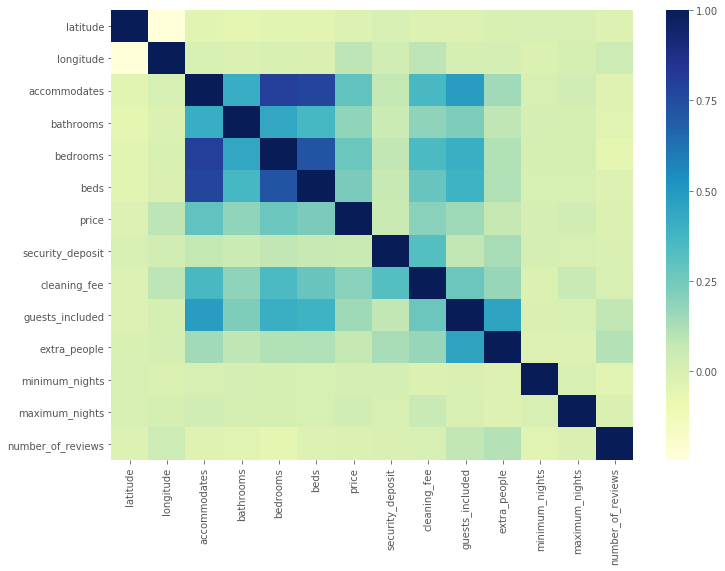

In [135]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(df.corr(), cmap="YlGnBu", ax=ax)

## 2 

Explore og inddel funktionerne og udfør foreløbige en feature selection

- Undersøg (kategorisk eller numerisk) af 105 forudsigere; pris er svarvariablen.

- Det indledende sæt vigtige funktioner  er vist nedenfor.


### <font color=orange>Indledende sæt a vigtige Numerical featues  og deres beskrivelser</font>

- <font color=black>**price</font>:** prisen per nat; responsvariabel, den vigtigste variabel
- <font color=black>**accommodates</font>:** antallet af gæster, som property kan rumme
- <font color=black>**bedrooms</font>:** antal soveværelser inkluderet i Property
- <font color=black>**bathrooms</font>:** antal badeværelser inkluderet i property

- <font color=black>**beds</font>:** antal senge inkluderet i lejen
- <font color=black>**minimum_nights</font>:** minimum antal nætter, en gæst kan overnatte for lejen
- <font color=black>**maximum_nights</font>:** maksimale antal nætter, en gæst kan overnatte for lejen
- <font color=black>**number_of_reviews</font>:** antal anmeldelser, som tidligere gæster har forladt
- <font color=black>**security_deposit</font>:** kræves baseret på ejendomstype eller opholdets længde
- <font color=black>**cleaning_fee</font>:** cleaning omkostning /gebyr 
- <font color=black>**guests_included</font>:** antal gæster booker ønsker at inkludere
- <font color=black>**extra_people</font>:** udgifter til ekstra person per nat
- <font color=black>**latitude</font>:** lokation coordinate; 
- <font color=black>**longitude</font>:** lokation coordinate; 

### <font color=red>Første sæt a de vigtigste kategoriske funktioner og deres beskrivelser</font>

- <font color=red>**calendar_updated</font>:**Dato for fast ejendom  opdatere løbende
- <font color=red>**property_type</font>:** house, townhouse, apartment, condo, hostel, cabin, etc.
- <font color=red>**room_type</font>:** entire home/apt, private room or shared room
- <font color=red>**bed_type</font>:** real bed, pull-out sofa, futon, airbed, and couch.
- <font color=red>**neighbourhood_cleansed</font>:** neighborhood : Nørrebro,Indre by,Vesterbro
- <font color=red>**cancellation_policy</font>:** .annuleringsfunktion 
- <font color=red>**amenities</font>:** Wifi, TV, kitchen, smoke detector, air conditioning, etc.1 
- <font color=red>**instant_bookable</font>:** beskriver om en airbnb property med det samme kan bookes
- <font color=red>**host_is_superhost</font>:** beskriver stærkt vurderede og pålidelige værter 
- <font color=red>**host_has_profile_pic</font>:** hvorvidt værter har billeder på deres profil
- <font color=red>**host_identity_verified</font>:** hvorvidt værtens identitet er verificeret  eller ej.
- <font color=red>**require_guest_profile_picture</font>:** important feature since people tend to be hesistant about releasing their pictures.

De kombinerede numeriske og kategoriske features, der er anført ovenfor, er 26, men vil blive maksimeret yderligere ned til 24.



## Drop a set of uønskede features fra datasættet

In [11]:
keep_features = ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights', 
                 'maximum_nights', 'number_of_reviews', 'security_deposit', 'cleaning_fee', 
            'square_feet',      'guests_included', 'extra_people', 'latitude', 'longitude', 
                 'calendar_updated', 'property_type', 'room_type', 'bed_type', 
                 'neighbourhood_cleansed', 'cancellation_policy', 'amenities', 
                 'instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 
                 'host_identity_verified',  'require_guest_profile_picture']

drop_features = [i for i in listings.columns if i not in keep_features]

t1 = train.copy()
t1.drop(drop_features, axis=1, inplace=True)
train=t1.copy()

t2 = test.copy()
t2.drop(drop_features, axis=1, inplace=True)
test = t2.copy()


t3 = listings.copy()
t3.drop(drop_features, axis=1, inplace=True)
listings = t3.copy()

In [12]:
listings.shape

(28077, 27)

In [13]:
train.shape

(22462, 27)

In [14]:
test.shape

(5615, 27)

##  Kassere  af lister , der er mere end et år gamle



In [15]:
def discard_old_listings(df,drop_listings):
        
    more_than_12months=sorted(df[df['calendar_updated'].str.contains(
    'months ago')]['calendar_updated'].unique())
    
    more_than_12months=[i for i in more_than_12months if int(i[:-10])>12]
    
    if(drop_listings==False):  #Give the reader an idea of listings to be dropped
        #print('All listing periods=',df['calendar_updated'].unique(),'\n')
        print('Listing periods of at least a year old=',more_than_12months)
    
    if drop_listings==True:
        
        for i in more_than_12months:
            
            j=df[df['calendar_updated'].str.contains(i)].index
            
            df.drop(df.index[j],inplace=True)
            df.reset_index(drop=True,inplace=True)
        
        df.drop('calendar_updated', axis=1, inplace=True)
        
        return df
            

In [16]:
df=discard_old_listings(listings,False)
df=discard_old_listings(listings,True)

Listing periods of at least a year old= ['13 months ago', '14 months ago', '15 months ago', '16 months ago', '17 months ago', '18 months ago', '19 months ago', '20 months ago', '21 months ago', '22 months ago', '23 months ago', '24 months ago', '25 months ago', '26 months ago', '27 months ago', '28 months ago', '29 months ago', '30 months ago', '31 months ago', '32 months ago', '33 months ago', '34 months ago', '35 months ago', '36 months ago', '37 months ago', '38 months ago', '39 months ago', '40 months ago', '41 months ago', '42 months ago', '43 months ago', '44 months ago', '45 months ago', '46 months ago', '47 months ago', '48 months ago', '49 months ago', '50 months ago', '51 months ago', '52 months ago', '53 months ago', '54 months ago', '55 months ago', '56 months ago', '57 months ago', '58 months ago', '59 months ago', '60 months ago', '61 months ago', '62 months ago', '63 months ago', '64 months ago', '65 months ago', '66 months ago', '67 months ago', '68 months ago', '89 mon

In [17]:
train=discard_old_listings(train,True)

In [18]:
test=discard_old_listings(test,True)

In [19]:
listings.shape

(19170, 26)

In [20]:
train.shape

(15316, 26)

In [21]:
test.shape

(3854, 26)


## Rense Airbnb  Datasættet 


### Hurtig inspektion for at se, om uønskede tegn kan fjernes


In [22]:
def clean_data(df):
    
    for i in ['price','cleaning_fee','security_deposit', 'extra_people']:
        df[i]=df[i].str.replace('$','').str.replace(',', '').astype(float)
    
    df['amenities']=df['amenities'].str.replace('{}','').str.replace('{ }','')
    
    df['amenities']=df['amenities'].str.replace(
    '$','').str.replace('{','').str.replace('}','').str.replace(
    '"','').str.replace(' toilet','toilet').str.replace('Cable TV','TV')

    df.replace('', np.nan, inplace=True)
    
    return df
    

### Kontroller, at de uønskede tegn faktisk er blevet fjernet

In [23]:
listings=clean_data(listings)
train=clean_data(train)
test=clean_data(test)

In [24]:
listings.shape, train.shape, test.shape

((19170, 26), (15316, 26), (3854, 26))

In [25]:
listings[['amenities', 'price','cleaning_fee','security_deposit', 'extra_people']]

,amenities,price,cleaning_fee,security_deposit,extra_people
0,"TV,TV,Wifi,Kitchen,Paid parking off premises,H...",375.0,34.0,0.0,68.0
1,"TV,Wifi,Kitchen,Indoor fireplace,Heating,Famil...",2402.0,1100.0,5000.0,350.0
2,"TV,Internet,Wifi,Kitchen,Buzzer/wireless inter...",3098.0,523.0,3733.0,0.0
3,"Wifi,Kitchen,Paid parking off premises,Heating...",798.0,300.0,NaN,0.0
4,"TV,Internet,Wifi,Kitchen,Buzzer/wireless inter...",860.0,75.0,NaN,0.0
5,"TV,TV,Internet,Wifi,Kitchen,Buzzer/wireless in...",751.0,NaN,1000.0,100.0
6,"Internet,Wifi,Kitchen,Buzzer/wireless intercom...",573.0,NaN,NaN,0.0
7,"TV,TV,Internet,Wifi,Kitchen,Hot tub,Buzzer/wir...",1085.0,0.0,1493.0,336.0
8,"TV,TV,Internet,Wifi,Kitchen,Free parking on pr...",587.0,373.0,NaN,112.0
9,"Wifi,Kitchen,Paid parking off premises,Heating...",1003.0,NaN,NaN,0.0


In [26]:
train[['amenities', 'price','cleaning_fee','security_deposit', 'extra_people']]

,amenities,price,cleaning_fee,security_deposit,extra_people
0,"TV,Internet,Wifi,Kitchen,Paid parking off prem...",799.0,300.0,NaN,200.0
1,"TV,Wifi,Kitchen,Washer,Dryer,Essentials,Shampo...",342.0,NaN,NaN,0.0
2,"TV,TV,Wifi,Kitchen,Free parking on premises,Fr...",1297.0,800.0,4000.0,0.0
3,"TV,Wifi,Kitchen,Buzzer/wireless intercom,Heati...",628.0,150.0,2500.0,0.0
4,"TV,TV,Internet,Wifi,Kitchen,Paid parking off p...",3201.0,400.0,5000.0,200.0
5,"Wifi,Kitchen,Paid parking off premises,Smoking...",423.0,0.0,0.0,100.0
6,"TV,Kitchen,Free street parking,Heating,Family/...",560.0,200.0,0.0,0.0
7,"TV,Wifi,Kitchen,Free parking on premises,Eleva...",1297.0,300.0,NaN,0.0
8,"TV,Wifi,Kitchen,Heating,Washer,Smoke detector,...",498.0,150.0,0.0,150.0
9,"Elevator,Smoke detector,Essentials,Lock on bed...",751.0,NaN,NaN,0.0


In [27]:
test[['amenities', 'price','cleaning_fee','security_deposit', 'extra_people']]

,amenities,price,cleaning_fee,security_deposit,extra_people
0,"TV,TV,Internet,Wifi,Kitchen,Buzzer/wireless in...",1222.0,478.0,6824.0,136.0
1,"TV,Wifi,Kitchen,Buzzer/wireless intercom,Heati...",648.0,200.0,1500.0,0.0
2,"TV,Internet,Wifi,Kitchen,Indoor fireplace,Buzz...",1495.0,373.0,747.0,0.0
3,"Internet,Wifi,Kitchen,Paid parking off premise...",437.0,500.0,0.0,300.0
4,"TV,Wifi,Kitchen,Paid parking off premises,Heat...",1699.0,650.0,2000.0,350.0
5,"TV,Internet,Wifi,Kitchen,Elevator,Free street ...",1003.0,670.0,2500.0,300.0
6,"TV,TV,Internet,Wifi,Kitchen,Free parking on pr...",450.0,400.0,700.0,150.0
7,"TV,TV,Internet,Wifi,Kitchen,Free parking on pr...",450.0,0.0,0.0,150.0
8,"TV,Internet,Wifi,Kitchen,Paid parking off prem...",1092.0,300.0,0.0,100.0
9,"TV,TV,Internet,Wifi,Kitchen,Free parking on pr...",798.0,400.0,5000.0,0.0


### tjekkede for manglende værdier i de valgte features 

-  udskrive features med manglende værdier hurtigt
- adskille features  i kategoriske og numeriske undergrupper.
- vise kortfattet features med manglende værdier i en faldende rækkefølge af mangel.

#### Kontroller hurtigt, hvor meget data der mangler i både trænings- og testdatasættet

In [28]:
def quick_check_missing_data(df,data):
    print('features with missing data in {}'.format(data))
    print('________________________________________________')
    
    for i in df.columns.values:
        x=df.loc[df[i].isnull()][i]
        if len(x)>0:print(i,len(x))
    print('________________________________________________')
    print()


In [29]:
quick_check_missing_data(listings,'training data set')

features with missing data in training data set
________________________________________________
host_is_superhost 10
host_has_profile_pic 10
host_identity_verified 10
bathrooms 9
bedrooms 8
beds 7
amenities 18
square_feet 18848
security_deposit 8193
cleaning_fee 4865
________________________________________________



In [30]:
quick_check_missing_data(train,'training data set')

features with missing data in training data set
________________________________________________
host_is_superhost 8
host_has_profile_pic 8
host_identity_verified 8
bathrooms 6
bedrooms 4
beds 3
amenities 17
square_feet 15054
security_deposit 6533
cleaning_fee 3855
________________________________________________



In [31]:
quick_check_missing_data(test, 'test data set')

features with missing data in test data set
________________________________________________
host_is_superhost 2
host_has_profile_pic 2
host_identity_verified 2
bathrooms 3
bedrooms 4
beds 4
amenities 1
square_feet 3794
security_deposit 1660
cleaning_fee 1010
________________________________________________



#### Adskil funktionerne i kategoriske og numeriske sæt

In [32]:
def feature_identification(df):
    categorical_features = df.columns[df.dtypes == 'object']
    numerical_features = df.columns[df.dtypes != 'object']
    
    i=len(categorical_features)
    j=len(numerical_features)
    
    print('There are {} categorical features and {} numerical features'.format(i,j),'\n')
    print('categorical features={}'.format(sorted(categorical_features)),'\n')
    print('numerical features={}'.format(sorted(numerical_features)),'\n')
    
    return (categorical_features,numerical_features)

categorical_features,numerical_features=feature_identification(train)

There are 11 categorical features and 15 numerical features 

categorical features=['amenities', 'bed_type', 'cancellation_policy', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'instant_bookable', 'neighbourhood_cleansed', 'property_type', 'require_guest_profile_picture', 'room_type'] 

numerical features=['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'extra_people', 'guests_included', 'latitude', 'longitude', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit', 'square_feet'] 



#### Evaluer nu de manglende data i hvert datasæt korrekt

In [33]:
def check_var(i,numerical_features):
    if i in numerical_features: 
        return('numerical')
    else:
        return('categorical')
    
def check_missing_data(df,numerical_features):
    df2 = df.isnull().sum()
    df2.sort_values(axis=0,ascending=False,inplace=True)
    number_of_rows=len(df)
    missing_types=[check_var(i,numerical_features) for i in df2.index]
    headers=[tuple(df[i].head(n=5)) for i in df2.index]
    tmp1 = pd.DataFrame({'Feature':df2.index, 
                         'Missing values':df2.values})
    tmp1['Feature type']=pd.Series(missing_types, index=tmp1.index)
    tmp1['Percentage missing']=pd.Series(df2.values*100/number_of_rows, index=tmp1.index)
    tmp1['First 5 values']=pd.Series(headers, index=tmp1.index)
    return tmp1 


In [34]:
corr_df = df.corr().sort_values('price', ascending=False)['price'].reset_index()
corr_df.columns = ['feature', 'corr']
corr_df['corr_abs'] = corr_df['corr'].abs()

**Manglænde  data in hele datasættet**

In [35]:
tmp=check_missing_data(listings,numerical_features)
tmp[tmp['Percentage missing'] > 0.0]

,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,square_feet,18848,numerical,98.320292,"(97.0, nan, nan, nan, nan)"
1,security_deposit,8193,numerical,42.738654,"(0.0, 5000.0, 3733.0, nan, nan)"
2,cleaning_fee,4865,numerical,25.378195,"(34.0, 1100.0, 523.0, 300.0, 75.0)"
3,amenities,18,categorical,0.093897,"(TV,TV,Wifi,Kitchen,Paid parking off premises,..."
4,host_is_superhost,10,categorical,0.052165,"(t, t, f, f, f)"
5,host_has_profile_pic,10,categorical,0.052165,"(t, t, t, t, t)"
6,host_identity_verified,10,categorical,0.052165,"(f, f, t, f, t)"
7,bathrooms,9,numerical,0.046948,"(1.0, 1.5, 2.5, 1.0, 1.0)"
8,bedrooms,8,numerical,0.041732,"(1.0, 4.0, 6.0, 1.0, 3.0)"
9,beds,7,numerical,0.036515,"(1.0, 4.0, 8.0, 1.0, 3.0)"


#### Manglende data i træningsdatasættet

In [36]:
tmp=check_missing_data(train,numerical_features)
tmp[tmp['Percentage missing'] > 0.0]

,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,square_feet,15054,numerical,98.289371,"(nan, nan, nan, nan, nan)"
1,security_deposit,6533,numerical,42.654740,"(nan, nan, 4000.0, 2500.0, 5000.0)"
2,cleaning_fee,3855,numerical,25.169757,"(300.0, nan, 800.0, 150.0, 400.0)"
3,amenities,17,categorical,0.110995,"(TV,Internet,Wifi,Kitchen,Paid parking off pre..."
4,host_is_superhost,8,categorical,0.052233,"(f, f, f, f, f)"
5,host_has_profile_pic,8,categorical,0.052233,"(t, t, t, t, t)"
6,host_identity_verified,8,categorical,0.052233,"(t, f, f, f, t)"
7,bathrooms,6,numerical,0.039175,"(1.0, 1.0, 1.0, 1.0, 2.0)"
8,bedrooms,4,numerical,0.026116,"(1.0, 1.0, 4.0, 1.0, 2.0)"
9,beds,3,numerical,0.019587,"(0.0, 1.0, 6.0, 1.0, 2.0)"


#### Mangler  i testdatasættet

In [37]:
tmp=check_missing_data(test,numerical_features)
tmp[tmp['Percentage missing'] > 0.0]

,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,square_feet,3794,numerical,98.443176,"(1453.0, 474.0, nan, nan, nan)"
1,security_deposit,1660,numerical,43.072133,"(6824.0, 1500.0, 747.0, 0.0, 2000.0)"
2,cleaning_fee,1010,numerical,26.206539,"(478.0, 200.0, 373.0, 500.0, 650.0)"
3,beds,4,numerical,0.103788,"(1.0, 1.0, 5.0, 1.0, 4.0)"
4,bedrooms,4,numerical,0.103788,"(1.0, 1.0, 4.0, 1.0, 3.0)"
5,bathrooms,3,numerical,0.077841,"(1.5, 1.0, 1.0, 1.0, 1.0)"
6,host_is_superhost,2,categorical,0.051894,"(f, f, f, f, t)"
7,host_has_profile_pic,2,categorical,0.051894,"(t, t, t, t, t)"
8,host_identity_verified,2,categorical,0.051894,"(t, t, f, f, t)"
9,amenities,1,categorical,0.025947,"(TV,TV,Internet,Wifi,Kitchen,Buzzer/wireless i..."


##  Droppe visse funktioner og tilregne manglende data


#### Fra tabellen ovenfor har 11 features  manglende værdier. Vi håndterer de manglende features som følger:

- The feature square_feet vil blive droppet grundent alt for mange manglende værdier. 

- De manglende værdier i features security_deposit and cleaning_fee vil blive erstatet med nul-værdier.


- De manglende værdier i features bathrooms, beds, and bedrooms erstattes med deres respektive modale værdier.

-  De manglende værdier i features amenities, host_is_superhost, host_has_profile_pic, host_identity_verified and cancellation_policy håndteres ved at slette rækkerne, der indeholder de manglende data.


In [38]:
def drop_features_and_impute_values(df):
    df.drop('square_feet', axis=1, inplace=True)
    df['security_deposit'].fillna(0.0,inplace=True)
    df['cleaning_fee'].fillna(0.0,inplace=True)
    df['bathrooms'].fillna(df['bathrooms'].mode()[0], inplace=True)
    df['beds'].fillna(df['beds'].mode()[0], inplace=True)
    df['bedrooms'].fillna(df['bedrooms'].mode()[0], inplace=True)
    #df = df.dropna(axis=0, subset=['amenities'])
    #df = df.dropna(axis=0, subset=['host_is_superhost'])
    #df = df.dropna(axis=0, subset=['host_has_profile_pic'])
    #df = df.dropna(axis=0, subset=['host_identity_verified'])
    #df = df.dropna(axis=0, subset=['cancellation_policy'])
    df.dropna(inplace=True)
    df.reset_index(drop=True,inplace=True)

In [39]:
drop_features_and_impute_values(listings)

In [40]:
drop_features_and_impute_values(train)

In [41]:
drop_features_and_impute_values(test)

###  Kontrollere hvert datasæt rent faktisk er blevet renset, og at der ikke mangler nogen værdier

In [42]:
def check_cleaningness(df):
    print(df.shape)
    print(df.isnull().values.any())

In [43]:
check_cleaningness(listings)
check_missing_data(listings,numerical_features).head()

(19142, 25)
False


,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,require_guest_profile_picture,0,categorical,0.0,"(f, f, f, f, f)"
1,beds,0,numerical,0.0,"(1.0, 4.0, 8.0, 1.0, 3.0)"
2,host_has_profile_pic,0,categorical,0.0,"(t, t, t, t, t)"
3,host_identity_verified,0,categorical,0.0,"(f, f, t, f, t)"
4,neighbourhood_cleansed,0,categorical,0.0,"(Nrrebro, Indre By, Indre By, Vesterbro-Kongen..."


In [44]:
check_cleaningness(train)
check_missing_data(train,numerical_features).head()

(15291, 25)
False


,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,require_guest_profile_picture,0,categorical,0.0,"(f, f, f, f, f)"
1,beds,0,numerical,0.0,"(0.0, 1.0, 6.0, 1.0, 2.0)"
2,host_has_profile_pic,0,categorical,0.0,"(t, t, t, t, t)"
3,host_identity_verified,0,categorical,0.0,"(t, f, f, f, t)"
4,neighbourhood_cleansed,0,categorical,0.0,"(Nrrebro, Nrrebro, Bispebjerg, Vesterbro-Konge..."


In [45]:
check_cleaningness(test)
check_missing_data(test,numerical_features).head()

(3851, 25)
False


,Feature,Missing values,Feature type,Percentage missing,First 5 values
0,require_guest_profile_picture,0,categorical,0.0,"(f, t, f, f, f)"
1,beds,0,numerical,0.0,"(1.0, 1.0, 5.0, 1.0, 4.0)"
2,host_has_profile_pic,0,categorical,0.0,"(t, t, t, t, t)"
3,host_identity_verified,0,categorical,0.0,"(t, t, f, f, t)"
4,neighbourhood_cleansed,0,categorical,0.0,"(Frederiksberg, Vesterbro-Kongens Enghave, Fre..."



# 3. Datavisualisering og fjernelse af outliers

## 3(a) Histogram plot for Pris variablen
- undersøge fordelingen af priser via et histogram såvel som fordelingen af de logtransformerede priser.

- bruge priserne på distributionen, der følger en normal distribution tilstrækkeligt i at kunne  modellere med machine learning 

- være særligt opmærksomme på outliers, med ekstreme værdier og fjerne dem, inden man kan gør videre og modellere machine learning modellen.

In [46]:
def plot_price(df):
    plt.rcParams['figure.figsize']=(20,4)
    plt.style.use(style='ggplot')
    xxx,sub=plt.subplots(1,2)
    
    sub[0].hist(df.price, color='blue')
    sub[0].set_title('price; skewness=%.5f'%(df.price.skew()),fontsize=20)
    sub[0].set_xlabel('Price',fontsize=20)
    sub[0].tick_params(labelsize=16)
    
    sub[1].hist(np.log1p(df.price), color='blue')
    sub[1].set_title('Log transfromed price; skewness=%.5f'%(np.log1p(df.price).skew()),fontsize=20)
    sub[1].set_xlabel('log(Price)',fontsize=20)
    sub[1].tick_params(labelsize=16)
    
    plt.show()

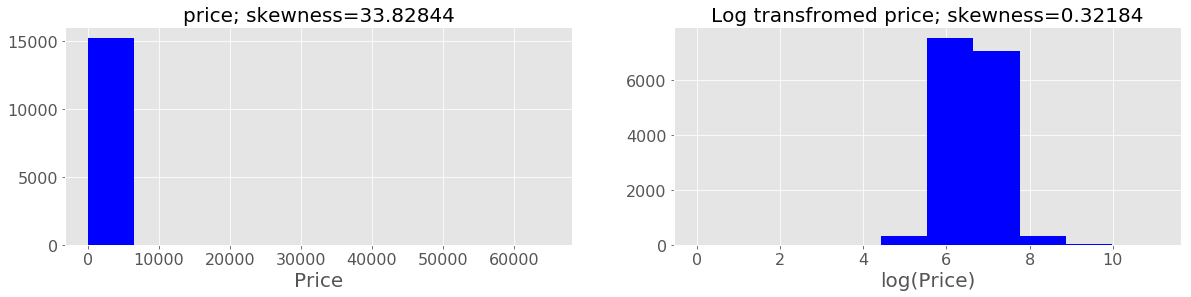

In [47]:
plot_price(train)

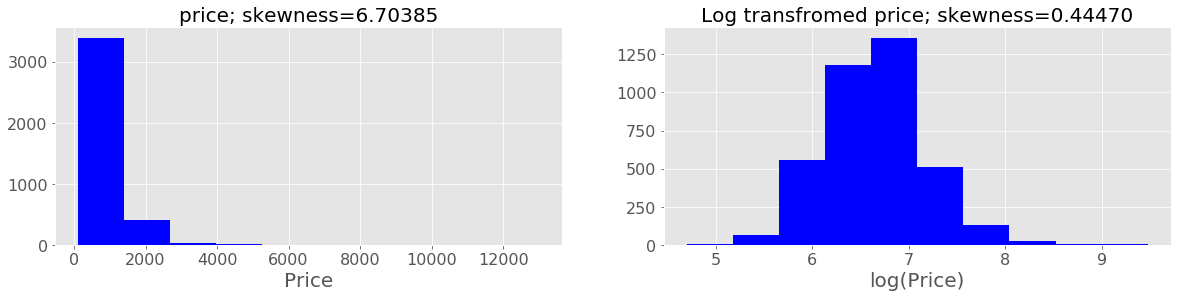

In [48]:
plot_price(test)

- Helt åbenlyst og absurd at nogle af priserne er ret ekstreme. Se prisfunktionens kvantitative egenskaber:

In [49]:
train['price'].describe()

count    15291.000000
mean       891.407429
std       1164.207882
min          0.000000
25%        553.000000
50%        751.000000
75%       1003.000000
max      64999.000000
Name: price, dtype: float64


- Denne gang kan man tegne grafen igen, men med priser, der ikke overstiger 5000.kr

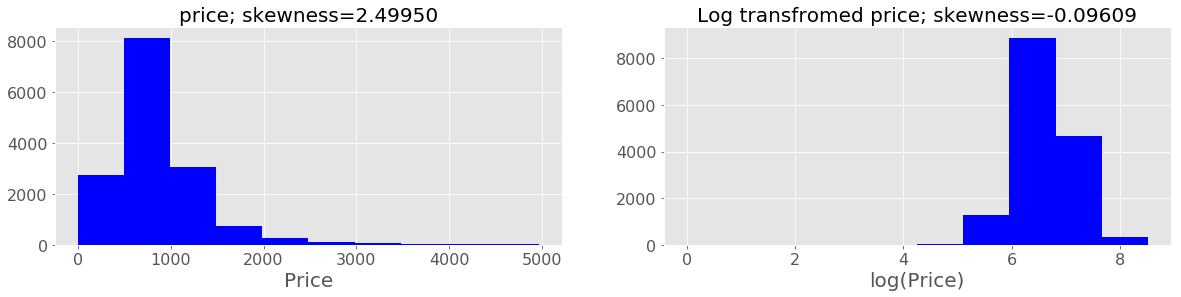

In [50]:
plot_price(train[train['price']<5000])

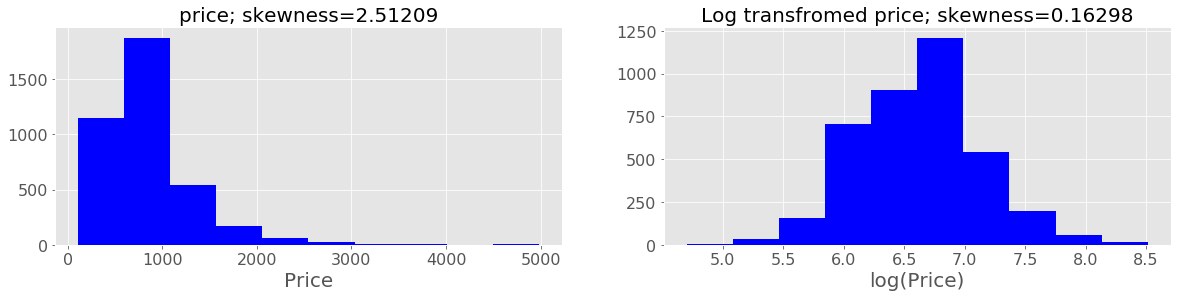

In [51]:
plot_price(test[test['price']<5000])

Det fremgår af plottet, at en lille brøkdel af priserne er over 5000. .

In [52]:
print('Training set: percentage of prices exceeding 5000dkk is {:0.4f}%'
      .format(train[train['price']>5000].count()[0]/train.shape[0]),'\n')

print('Test set: percentage of prices exceeding 5000dkk is {:0.4f}%'
      .format(test[test['price']>5000].count()[0]/test.shape[0]))

Training set: percentage of prices exceeding 5000dkk is 0.0031% 

Test set: percentage of prices exceeding 5000dkk is 0.0036%


Dette betyder at man skal behandle priser der overstiger 5000.kr  som outliers. Desuden vil der også blive fjernet nulpriser.

In [53]:
def remove_outliers(df,feature,low_value,high_value):
    df = df[df[feature]>low_value]
    df = df[df[feature]<=high_value]
    df.reset_index(drop=True,inplace=True)
    return df

In [54]:
train=remove_outliers(train,'price',0,5000)

In [55]:
train.shape

(15243, 25)

In [56]:
test=remove_outliers(test,'price',0,5000)

In [57]:
test.shape

(3837, 25)

## 3(b) Scatter plots a pris sammenlignet med de numeriske features

undersøge pris med hver numerisk feature

- opmærksomme på outliers i de numeriske funktioner og fjerne dem, hvor det er nødvendigt 

In [58]:
def features_plot(feat,df):
    plt.rcParams['figure.figsize']=(15,15)
    plt.style.use(style='ggplot')
    xxx,sub=plt.subplots(5,3)
    xxx.subplots_adjust(hspace=0.5)
    sub=sub.flatten()
    for i in range(len(feat)):
        sub[i].scatter(x=df[feat[i]], y=np.log1p(df["price"]),s=4)
        sub[i].set_title('{}'.format(feat[i],fontsize=10))
#        sub[i].set_ylabel('log(SalePrice)',fontsize=20)
        sub[i].tick_params(labelsize=10)
    plt.show()


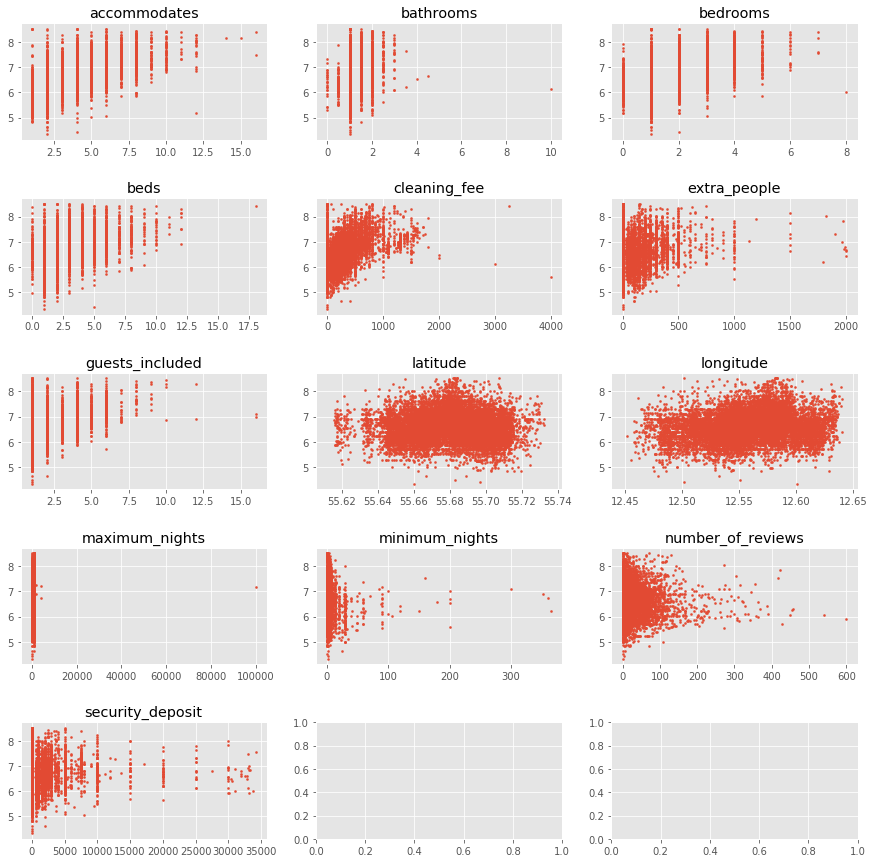

In [59]:
numerical_features = list(train.columns[train.dtypes != 'object'])
numerical_features.remove('price')
features_plot(sorted(numerical_features),train)

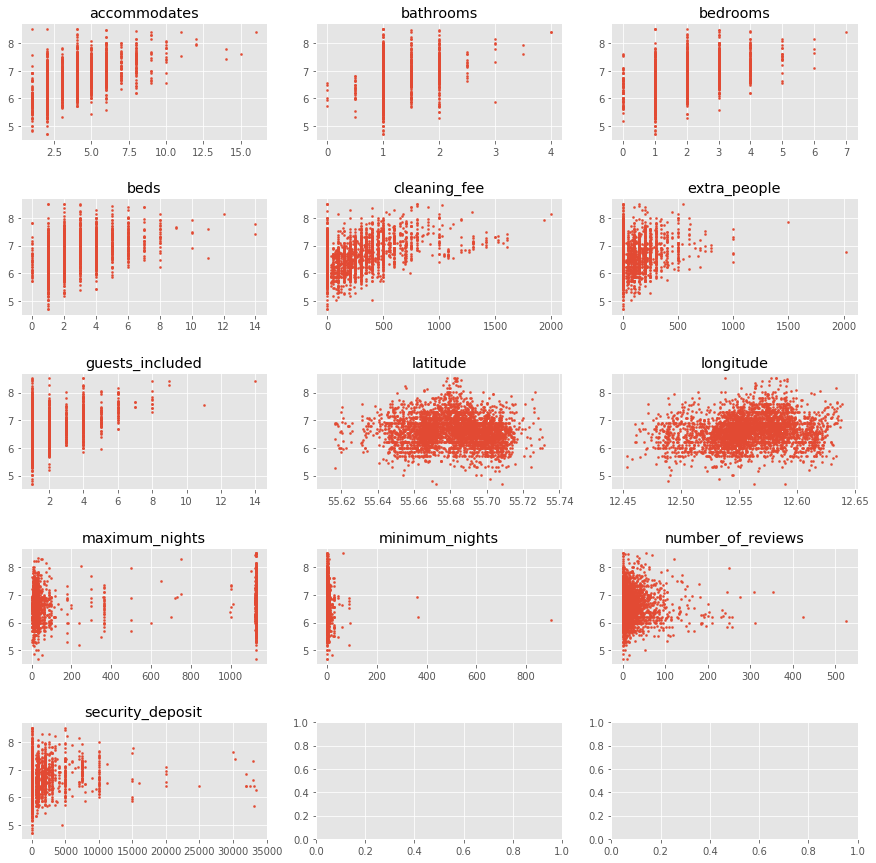

In [60]:
numerical_features = list(test.columns[test.dtypes != 'object'])
numerical_features.remove('price')
features_plot(sorted(numerical_features),test)

### Removing outliers from maximum_nights and minimum_nights

- Det er helt åbenlyst at  maximum_nights and minimum_nights haroutliers.

- Løsning : Begrænse, dem.Begrænse maksimumnætter til maksimalt 1200 og minimumnætter til højst 500.
 


In [61]:
def outliers(df,cut_off_max,cut_off_min,title):
    df3=df[df['maximum_nights']<cut_off_max]
    df2=df
    plt.rcParams['figure.figsize']=(20,4)
    plt.style.use(style='ggplot')
    xxx,sub=plt.subplots(1,2)
    xxx.subplots_adjust(hspace=1)

    sub[0].scatter(x=df2['maximum_nights'], y=np.log1p(df2["price"]), color='blue')
    sub[0].set_xlabel('maximum_nights',fontsize=25)
    sub[0].set_title('With outliers',fontsize=25)
    sub[0].set_ylabel('log(price)',fontsize=25)
    sub[0].tick_params(labelsize=25)

    sub[1].scatter(x=df3['maximum_nights'], y=np.log1p(df3["price"]), color='blue')
    sub[1].set_xlabel('maximum_nights',fontsize=25)
    sub[1].set_title(title,fontsize=25)
    sub[1].set_ylabel('log(price)',fontsize=25)
    sub[1].tick_params(labelsize=25)
    plt.show()

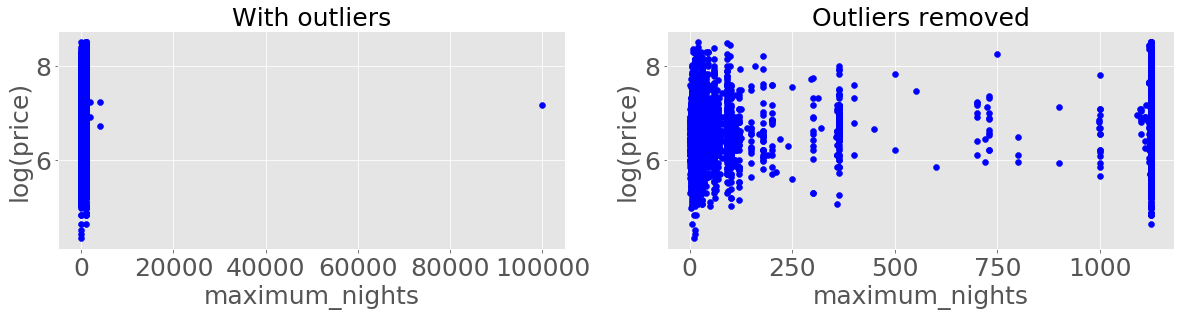

In [62]:
outliers(train,1200,500,'Outliers removed')

In [63]:
def plot_max_and_min_nights(df,cut_off_max,cut_off_min,title):
    df2=df[df['maximum_nights']<cut_off_max]
    df3=df[df['minimum_nights']<cut_off_min]
    plt.rcParams['figure.figsize']=(20,4)
    plt.style.use(style='ggplot')
    xxx,sub=plt.subplots(1,2)
    xxx.subplots_adjust(hspace=1)

    sub[0].scatter(x=df2['maximum_nights'], y=np.log1p(df2["price"]), color='red')
    sub[0].set_xlabel('maximum_nights',fontsize=25)
    sub[0].set_title(title,fontsize=25)
    sub[0].set_ylabel('log(price)',fontsize=25)
    sub[0].tick_params(labelsize=25)

    sub[1].scatter(x=df3['minimum_nights'], y=np.log1p(df3["price"]), color='blue')
    sub[1].set_xlabel('minimum_nights',fontsize=25)
    sub[1].set_title(title,fontsize=25)
    sub[1].set_ylabel('log(price)',fontsize=25)
    sub[1].tick_params(labelsize=25)
    plt.show()

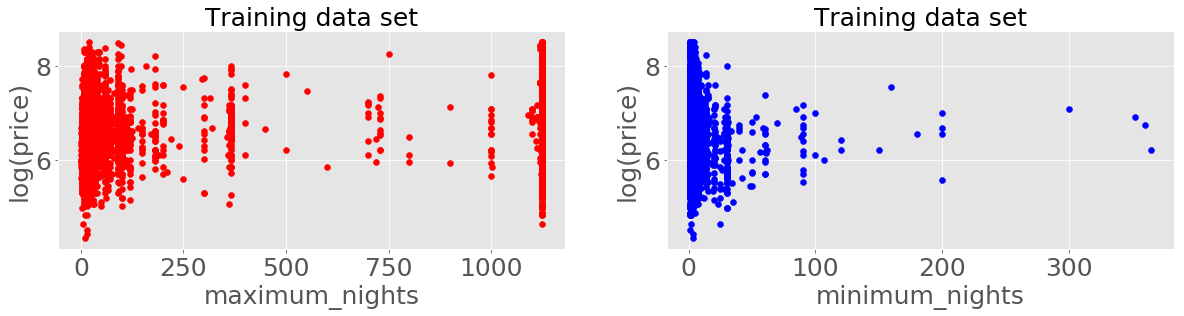

In [64]:
plot_max_and_min_nights(train,1200,500,'Training data set')

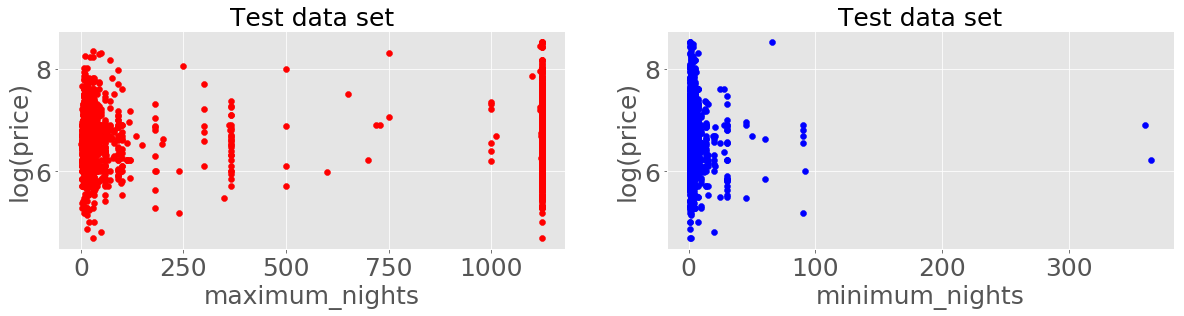

In [65]:
plot_max_and_min_nights(test,1200,500,'Test data set')


- Vi vil gå videre og kassere maksimum_nætter, der overstiger 1000 og minimum_nætter, der overstiger 500

In [66]:
train=remove_outliers(train,'maximum_nights',0,1200)
train=remove_outliers(train,'minimum_nights',0,500)
train.shape

(15238, 25)

In [67]:
test=remove_outliers(test,'maximum_nights',0,1200)
test=remove_outliers(test,'minimum_nights',0,500)
test.shape

(3836, 25)

## 3(c) Average and median price  af hver property type

- Der er 36 unikke forskellige ejendomme i Københavns InsideAirbnb Datasættet. Det interessante er at se hvor ofte en given ejendom vises og ligeledes visualisere den gennemsnitlige og medianpris per ejendom.


In [68]:
from matplotlib.ticker import FuncFormatter

In [69]:
def plot_property(df,title):
    all_properties=df['property_type'].tolist()
    fdist = FreqDist(all_properties)
    prop = pd.DataFrame({'Property': list(fdist.keys()),'Count': list(fdist.values())})
    prop = prop.nlargest(columns="Count", n = 10)
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)
    plt.style.use(style='ggplot')
    prop.plot(x='Property',y='Count',kind='bar',color='red')
    plt.ylabel('Frequency',fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    plt.tick_params(labelsize=20)
    plt.xticks(rotation='vertical')
    plt.legend(fontsize=22)
    plt.show()

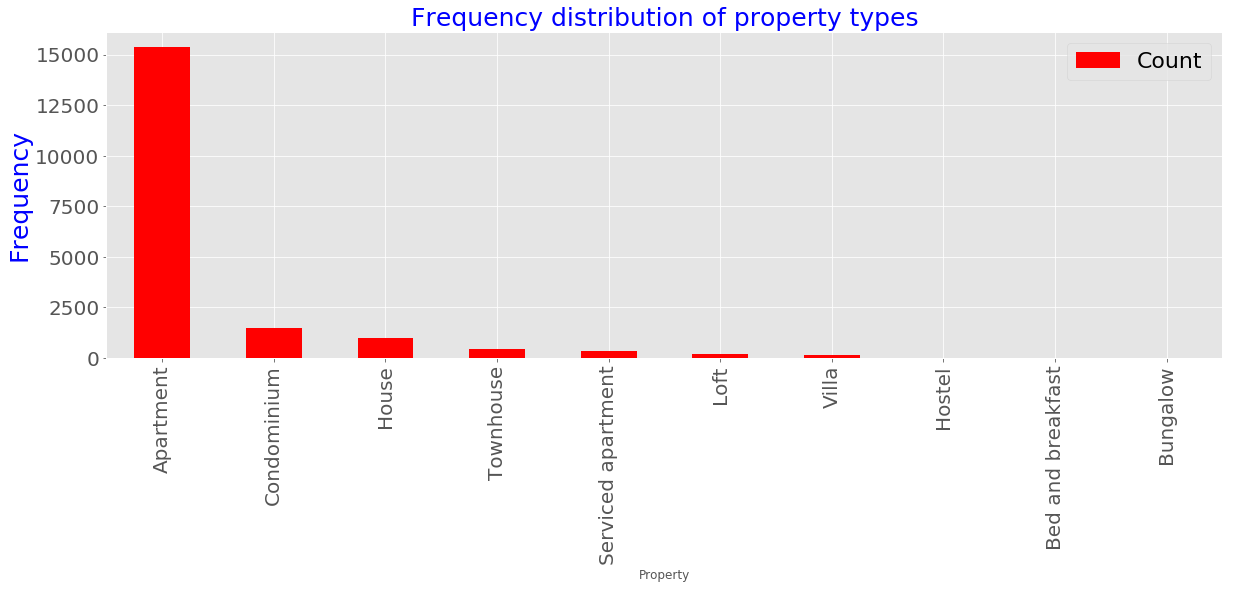

In [70]:
df = listings
title='Frequency distribution of property types'
plot_property(df,title)

In [71]:
listings.property_type.value_counts()

Apartment                 15352
Condominium                1490
House                       978
Townhouse                   449
Serviced apartment          331
Loft                        217
Villa                       129
Hostel                       27
Bed and breakfast            25
Guesthouse                   19
Bungalow                     19
Guest suite                  17
Hotel                        15
Boat                         15
Houseboat                    15
Tiny house                   14
Boutique hotel                9
Cabin                         7
Cottage                       5
Hut                           3
Camper/RV                     2
Barn                          1
Island                        1
Tent                          1
Casa particular (Cuba)        1
Name: property_type, dtype: int64

In [72]:
listings.shape

(19142, 25)

In [73]:
def category_count_plot(col, figsize=(8,4)):
  
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

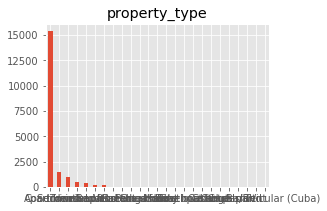

Apartment                 0.802006
Condominium               0.077839
House                     0.051092
Townhouse                 0.023456
Serviced apartment        0.017292
Loft                      0.011336
Villa                     0.006739
Hostel                    0.001411
Bed and breakfast         0.001306
Guesthouse                0.000993
Bungalow                  0.000993
Guest suite               0.000888
Hotel                     0.000784
Boat                      0.000784
Houseboat                 0.000784
Tiny house                0.000731
Boutique hotel            0.000470
Cabin                     0.000366
Cottage                   0.000261
Hut                       0.000157
Camper/RV                 0.000104
Barn                      0.000052
Island                    0.000052
Tent                      0.000052
Casa particular (Cuba)    0.000052
Name: property_type, dtype: float64


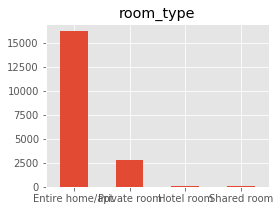

Entire home/apt    0.846672
Private room       0.146954
Hotel room         0.003343
Shared room        0.003030
Name: room_type, dtype: float64


In [74]:

for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

In [75]:
def plot_average_price(feature,label,df,nlength,title,color1,color2):
    
    sort_price = df.groupby(feature)['price'].mean().sort_values(ascending=False)
    sort_price = sort_price.to_frame().reset_index()
    sort_price.rename(columns ={feature:label,
                           'price':'average price'}, inplace=True)
    
    d = sort_price.copy()
    d = d.nlargest(columns="average price", n =min(len(d),nlength))
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)

    d.plot(x=label, y='average price', kind="bar",color=color1)

    plt.ylabel('Average price',fontsize=25,color=color2)
    plt.title(title,fontsize=25,color=color2)
    plt.tick_params(labelsize=22)
    plt.legend(fontsize=20)
    plt.xticks(rotation='vertical')
    plt.show()

def plot_median_price(feature,label,df,nlength,title,color1,color2):
    
    sort_price = df.groupby(feature)['price'].median().sort_values(ascending=False)
    sort_price = sort_price.to_frame().reset_index()
    sort_price.rename(columns ={feature:label,
                           'price':'median price'}, inplace=True)
    
    d = sort_price.copy()
    d = d.nlargest(columns="median price", n =min(len(d),nlength))
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)

    d.plot(x=label, y='median price', kind="bar",color=color1)
 
    plt.ylabel('Median price',fontsize=25,color=color2)
    plt.title(title,fontsize=25,color=color2)
  
    plt.legend(fontsize=20)
    plt.tick_params(labelsize=22)
    plt.xticks(rotation='vertical')
    plt.show()


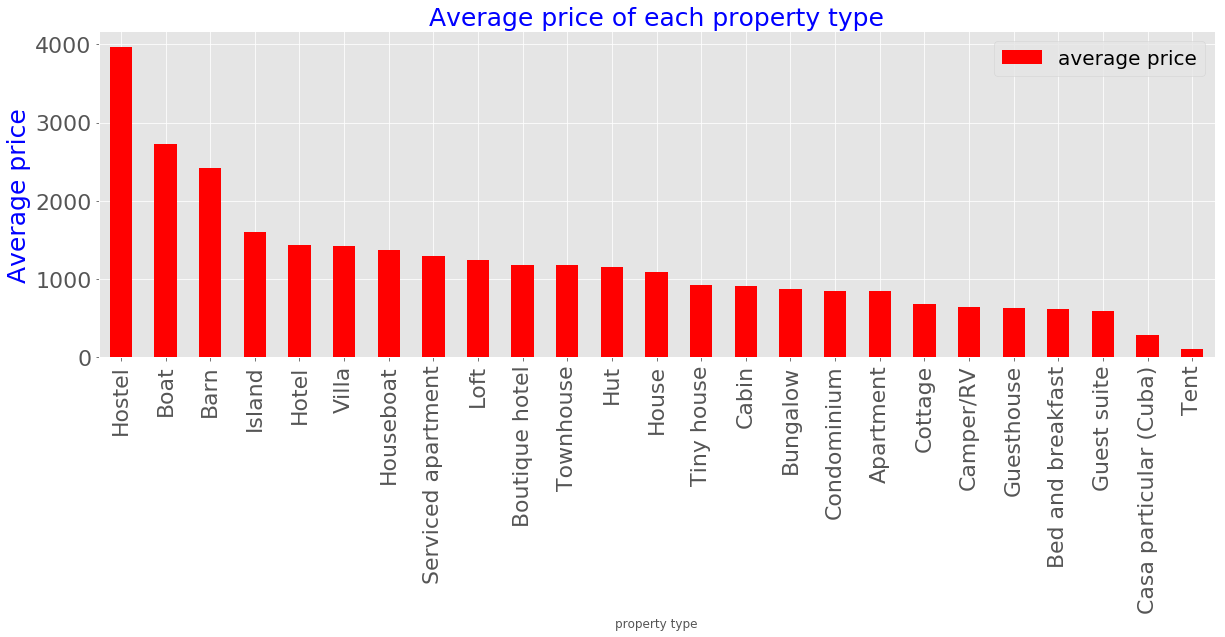

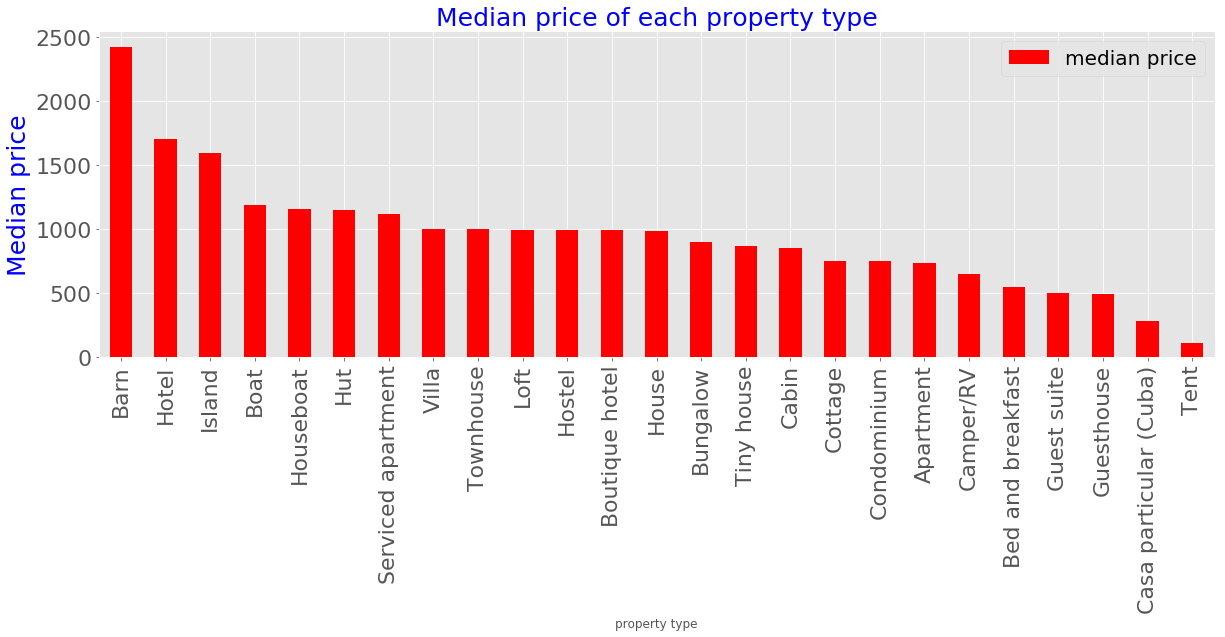

In [76]:
df=listings
title1 = 'Average price of each property type'
title2 = 'Median price of each property type'

plot_average_price('property_type','property type',df,30,title1,'red','blue')
plot_median_price('property_type','property type',df,30,title2,'red','blue')

In [77]:


train['room_type'].value_counts()

Entire home/apt    12897
Private room        2243
Hotel room            52
Shared room           46
Name: room_type, dtype: int64

In [78]:
train['room_type'].value_counts(normalize=True)

Entire home/apt    0.846371
Private room       0.147198
Hotel room         0.003413
Shared room        0.003019
Name: room_type, dtype: float64

In [79]:
roomtype_value_counts = [ 12897, 2243, 52]

In [80]:
roomtypes = ['Entire home/apt : 84 %','Private room 14,7 % ','Shared room 0,003 %']

In [81]:


listings.groupby('room_type')['price'].mean()

room_type
Entire home/apt     953.169495
Hotel room         2676.953125
Private room        501.343761
Shared room         386.137931
Name: price, dtype: float64

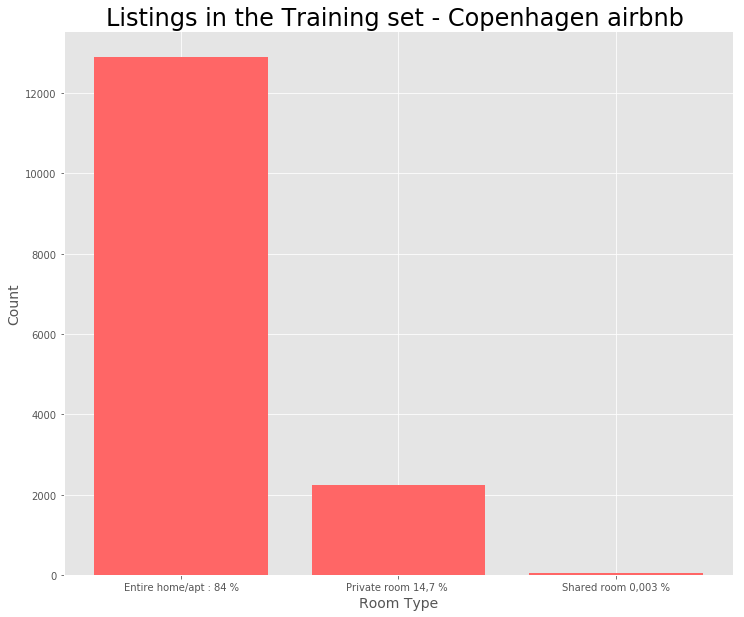

In [82]:

plt.figure(figsize=(12, 10))
plt.bar(x=roomtypes, height=roomtype_value_counts, color='#FF6666')
plt.title('Listings in the Training set - Copenhagen airbnb ', fontdict={'fontsize': 24})
plt.xlabel('Room Type', fontdict={'fontsize': 14})
plt.ylabel("Count", fontdict={'fontsize': 14});

## 3(d) Distribution af lister for Københavns  kvarterer

-Hvordan er listerne fordelt over kvarterer?




In [83]:
def plot_neighboorhood(df,title,nthreshhold):
    print("Number of neighboorhoods in Copenhagen", df.neighbourhood_cleansed.nunique(),'\n')
    listings_per_nbhood = df['neighbourhood_cleansed'].value_counts()

    acceptable_nbhood = listings_per_nbhood[listings_per_nbhood >=nthreshhold].index
    acceptable_listings = df[df['neighbourhood_cleansed'].isin(acceptable_nbhood)]
    listings_per_nbhood = acceptable_listings['neighbourhood_cleansed'].value_counts()
   
    listings_per_nbhood.to_frame()
    listings_per_nbhood.columns = ['neighborhood','count']
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize']=(20,6)
    listings_per_nbhood.plot(x="neighborhood", y='count', kind="bar")
 
    plt.ylabel('Number of listings',fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')

    plt.tick_params(labelsize=22)
    plt.legend(fontsize=22)
    plt.show()

Number of neighboorhoods in Copenhagen 11 



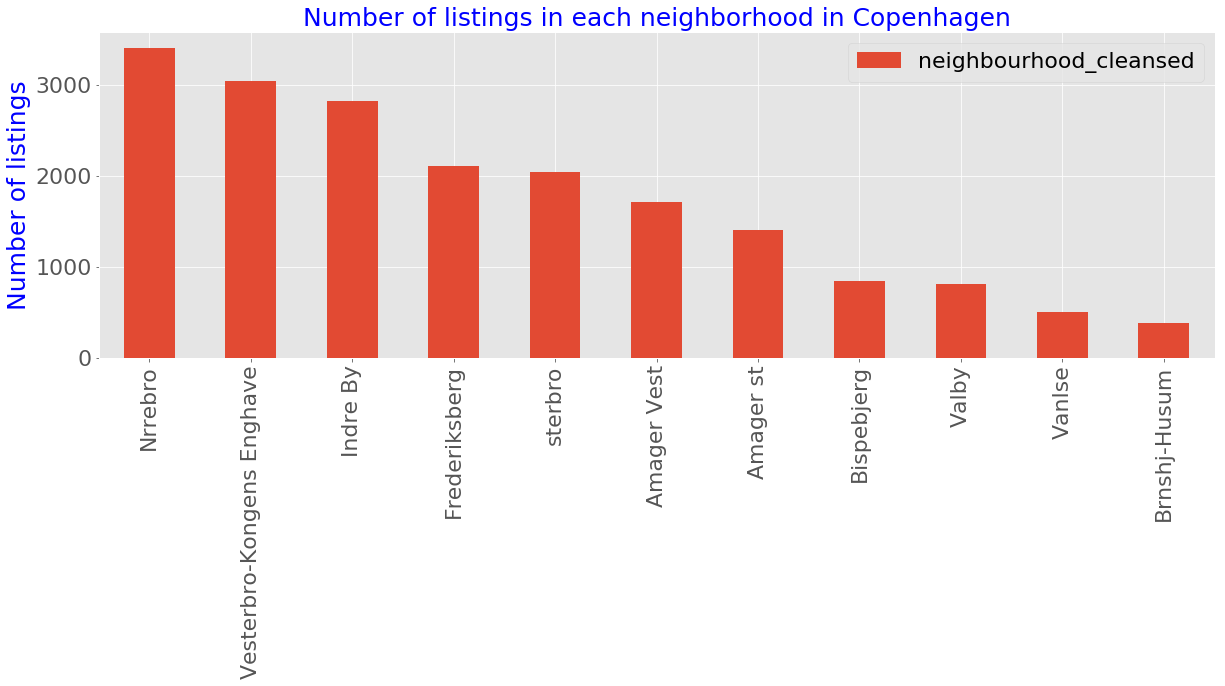

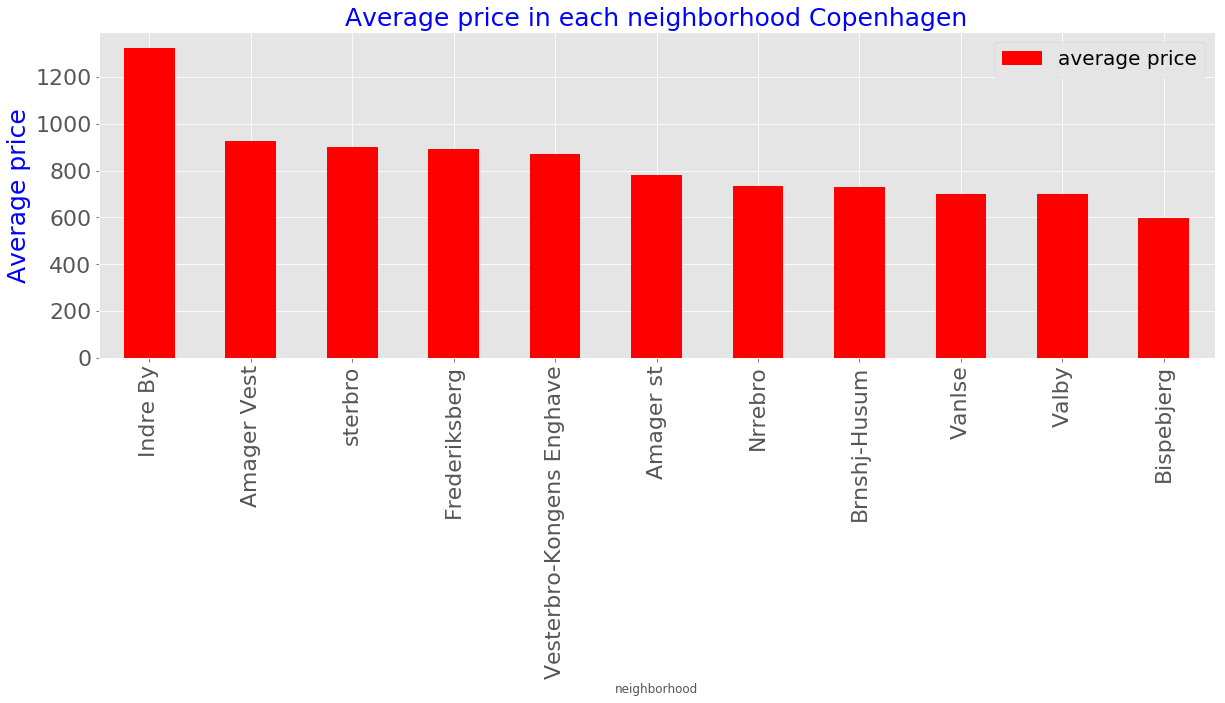

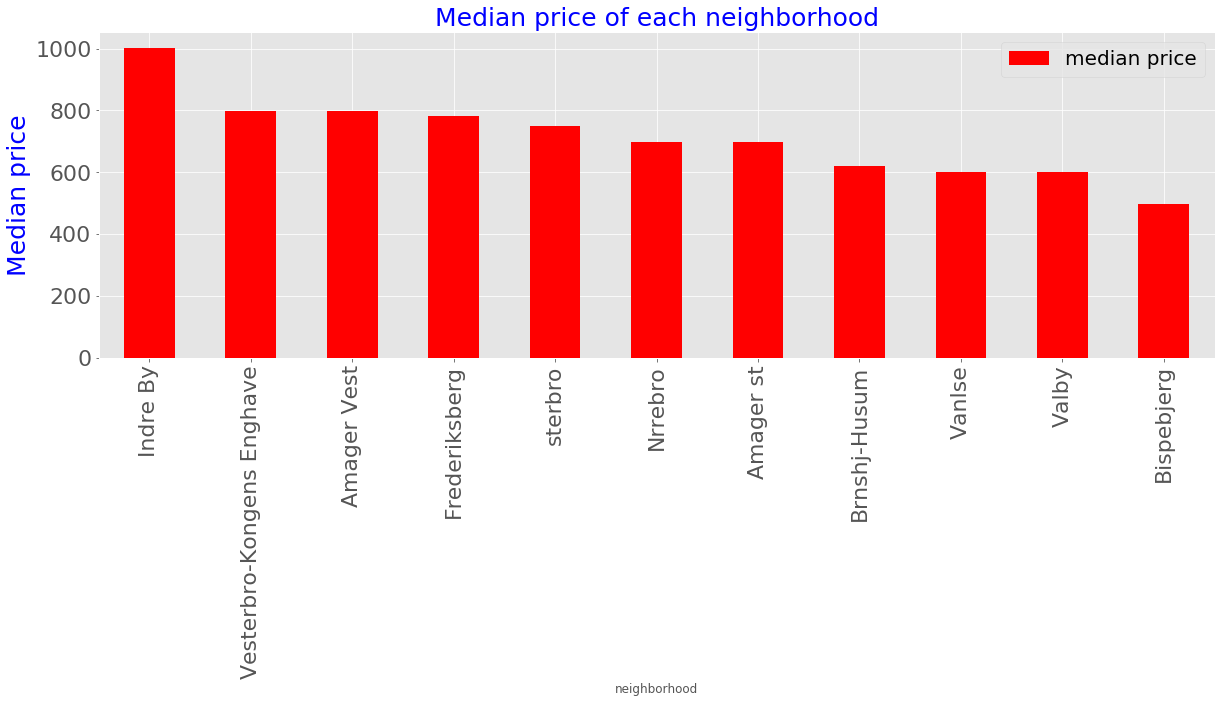

In [84]:
df = listings
nthreshhold=250
nshow=25

title1 = 'Number of listings in each neighborhood in Copenhagen'
title2 = 'Average price in each neighborhood Copenhagen'
title3 = 'Median price of each neighborhood'

plot_neighboorhood(df,title1,nthreshhold)
plot_average_price('neighbourhood_cleansed','neighborhood',df,nshow,title2,'red','blue')
plot_median_price('neighbourhood_cleansed','neighborhood',df,nshow,title3,'red','blue')

In [85]:
# Create a list of top 20 neighbourhoords in terms of listings
top = df['neighbourhood_cleansed'].value_counts().iloc[:20].index.tolist()

In [86]:
# Create a dataframe to group neighbourhoods by average room price
price = pd.DataFrame(df.groupby(['neighbourhood_cleansed']).price.mean().reset_index())

# Create a dataframe to filter top 20 neighbourhoods
top_price = price[price['neighbourhood_cleansed'].isin(top)].sort_values('price',ascending=False)

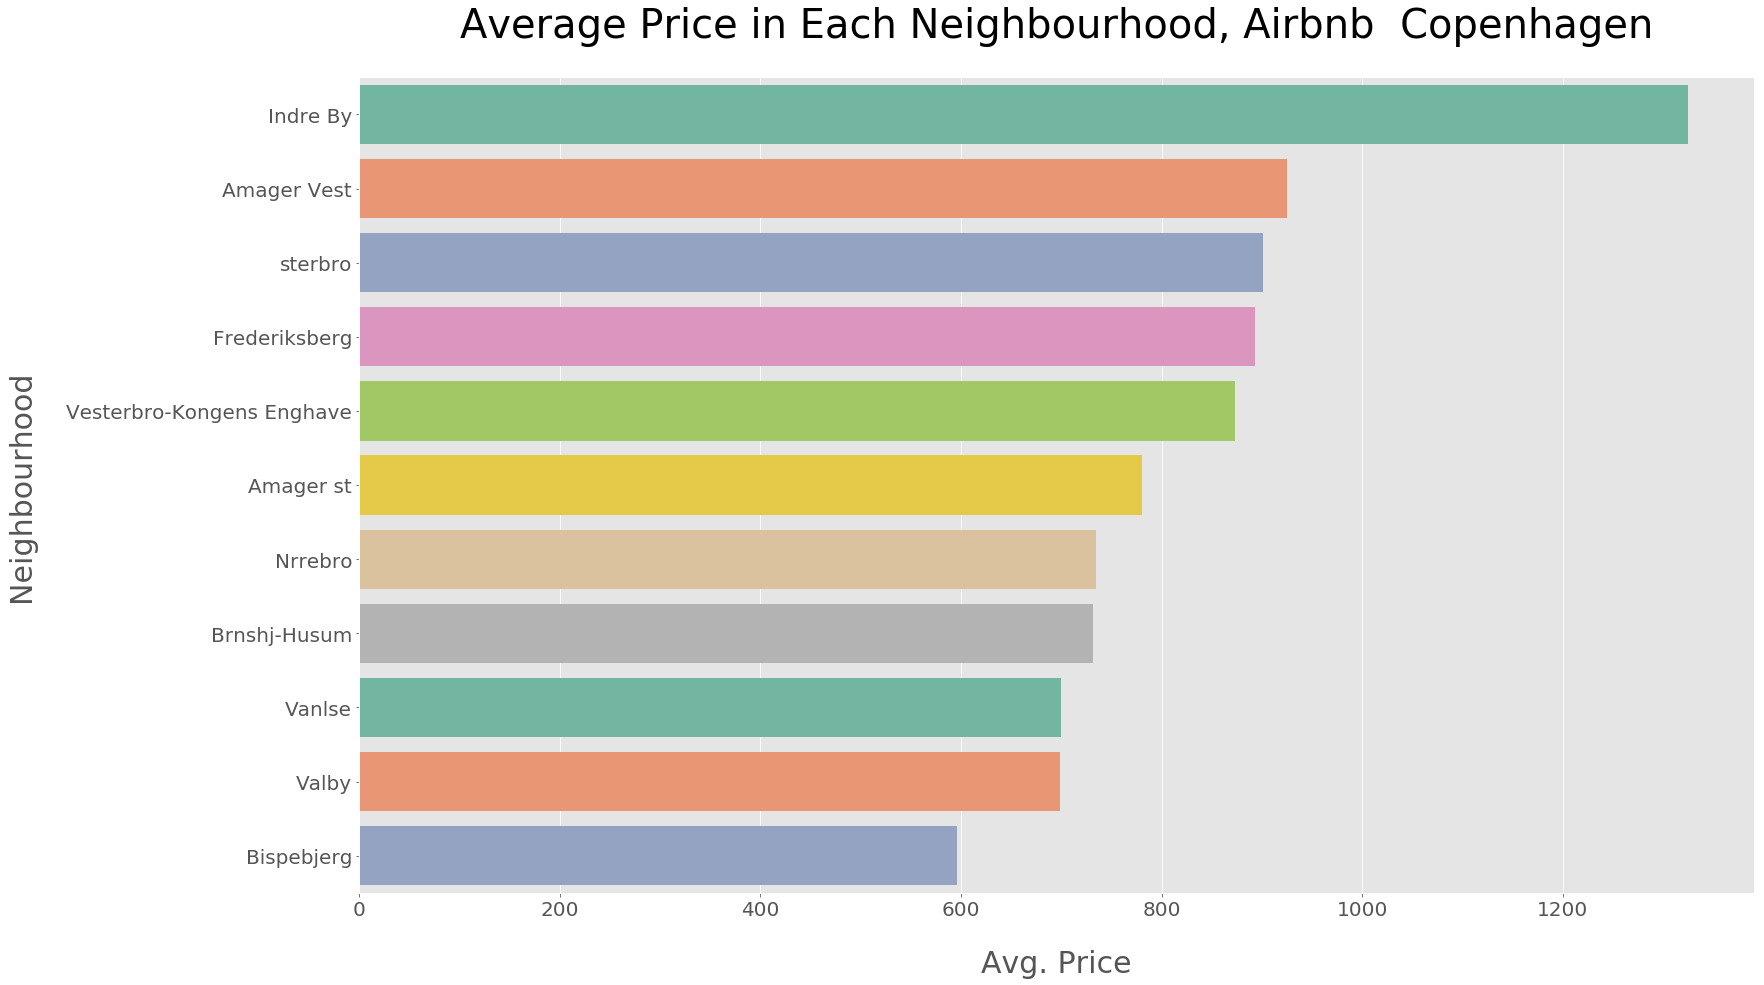

In [87]:

fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.axes.set_title("Average Price in Each Neighbourhood, Airbnb  Copenhagen",fontsize=40, pad=40)
ax = sns.barplot(x='price', y='neighbourhood_cleansed',data=top_price, palette='Set2')
ax.set_xlabel('Avg. Price',fontsize=30,labelpad=30)
ax.set_ylabel('Neighbourhood',fontsize=30,labelpad=30)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

In [88]:
top_price

,neighbourhood_cleansed,price
5,Indre By,1324.304209
0,Amager Vest,925.091173
10,sterbro,900.876525
4,Frederiksberg,893.017486
9,Vesterbro-Kongens Enghave,872.704568
1,Amager st,780.352482
6,Nrrebro,734.693907
3,Brnshj-Husum,731.677749
8,Vanlse,700.121032
7,Valby,698.438575


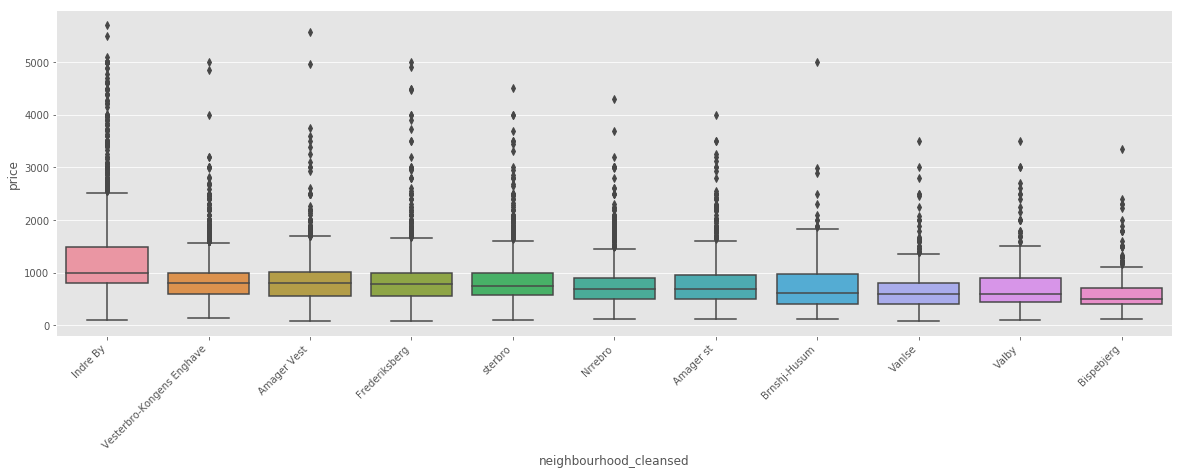

In [89]:
sort_price = df.loc[(df.price <= 23900) & (df.price > 0)]\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=df.loc[(df.price <= 5900) & (df.price > 0)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [90]:
def category_count_plot(col, figsize=(20,6)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

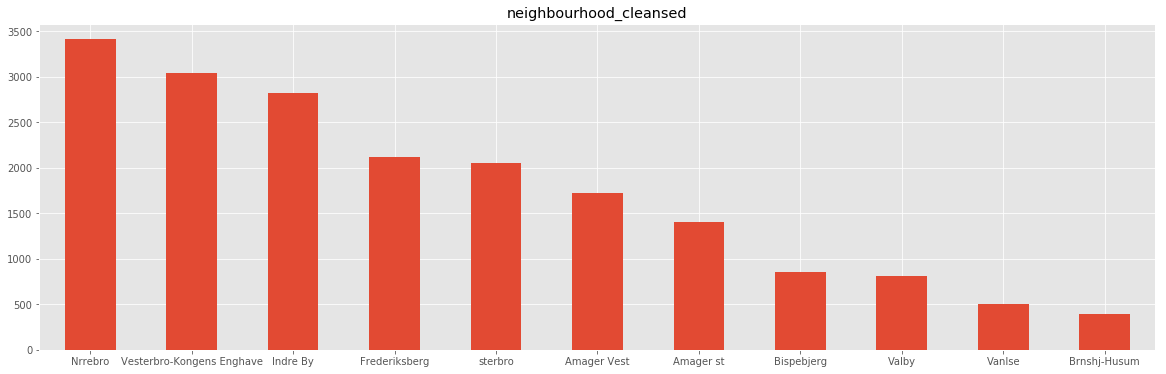

Nrrebro                      0.178351
Vesterbro-Kongens Enghave    0.158970
Indre By                     0.147686
Frederiksberg                0.110542
sterbro                      0.107042
Amager Vest                  0.089959
Amager st                    0.073660
Bispebjerg                   0.044509
Valby                        0.042524
Vanlse                       0.026330
Brnshj-Husum                 0.020426
Name: neighbourhood_cleansed, dtype: float64


KeyError: 'count'

<Figure size 1440x432 with 0 Axes>

In [91]:
for col in ['neighbourhood_cleansed','count']:
    category_count_plot(col, figsize=(20,6))
    print(df[col].value_counts(normalize=True))
    

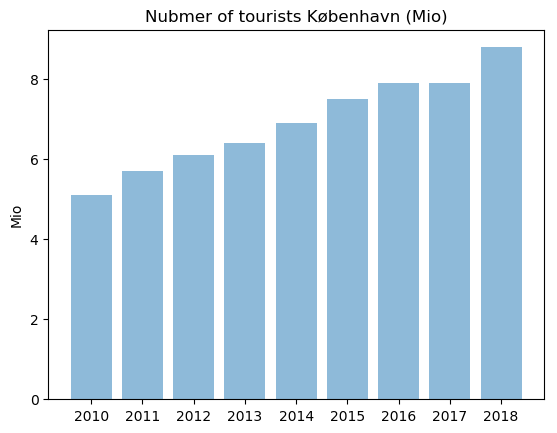

In [10]:

objects = ('2010', '2011', '2012', '2013', '2014', '2015','2016', '2017', '2018')
y_pos = np.arange(len(objects))
performance = [5.1,5.7,6.1,6.4,6.9,7.5,7.9,7.9,8.8]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mio')
plt.title('Nubmer of tourists København (Mio)')

plt.show()

### 3(e) Distribution af Pris ved at kigge på de forskellige rumtyper

 - Hvordan varierer priserne i forhold til forskellige rumtypes
 

Text(0.5, 0, 'Listing price in DKK')

<Figure size 864x432 with 0 Axes>

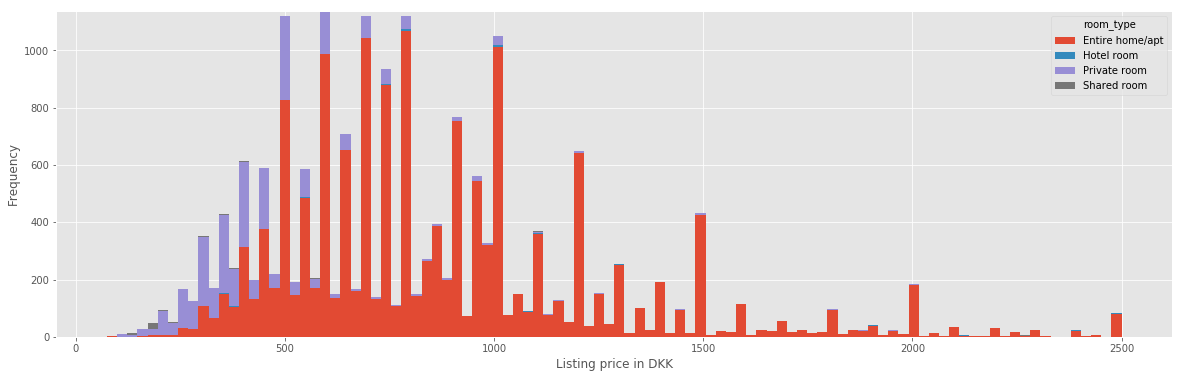

In [92]:
plt.figure(figsize=(12,6))
df.loc[(df.price <= 2500) & (df.price > 0)].pivot(columns = 'room_type', values = 'price').plot.hist(stacked = True, bins=100)
plt.xlabel('Listing price in DKK')



In [93]:
def plot_price_wrt_room_type(df,title):
    df2 = df.pivot(columns='room_type',values='price')
    x1=list(df2[df2.columns[0]])
    x2=list(df2[df2.columns[1]])
    x3=list(df2[df2.columns[2]])

    plt.rc('legend',**{'fontsize':25})
    plt.rcParams['figure.figsize']=(15,8)
    plt.style.use(style='ggplot')
    plt.tick_params(labelsize=25)
    plt.ylabel("Count",fontsize=25,color='blue')
    plt.xlabel("Price",fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    plt.tick_params(labelsize=25)
    n_bins=12
    colors = ['yellow', 'red', 'green']
    labels=[df2.columns[0],df2.columns[1],df2.columns[2]]
    plt.hist([x1, x2, x3], n_bins, histtype='bar', 
             color=colors, range=[0,2200],label=labels,alpha=1)       
    plt.legend(loc="upper right")
    plt.show()

C:\Users\fatih\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\fatih\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


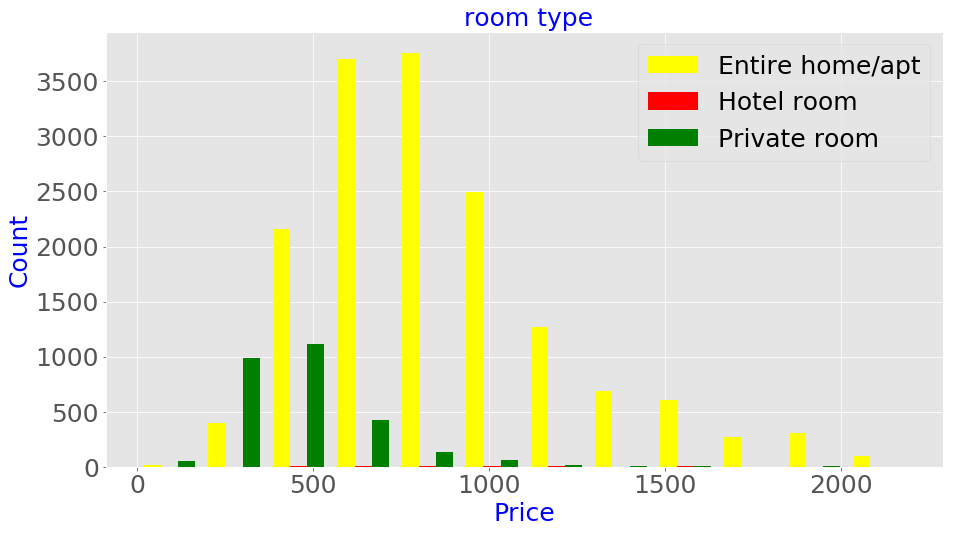

In [94]:
df=listings
title=' room type'
plot_price_wrt_room_type(df,title)

In [95]:
def plot_price_wrt_number_of_beds(df,title):
    df2 = df.pivot(columns='beds',values='price')
    x=[list(df2[df2.columns[i]]) for i in range(len(df2.columns)) if i <= 10]
    labels=[str(int(df2.columns[i]))+' beds' for i in range(len(df2.columns))]

    plt.rc('legend',**{'fontsize':20})
    plt.rcParams['figure.figsize']=(15,8)
    plt.style.use(style='ggplot')
    plt.tick_params(labelsize=14)
    plt.ylabel("Count",fontsize=25,color='blue')
    plt.xlabel("Price",fontsize=25,color='blue')
    plt.title(title,fontsize=25,color='blue')
    plt.tick_params(labelsize=25)
    n_bins=12
    plt.hist(x, n_bins, stacked=True,range=[0,3000],label=labels)        
    plt.legend(loc="upper right")
    plt.show()

### 3 (f) Distributionspris med hensyn til antal senge?

  - Hvordan varierer priserne med hensyn til antallet af senge i datasættet
 

C:\Users\fatih\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\fatih\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


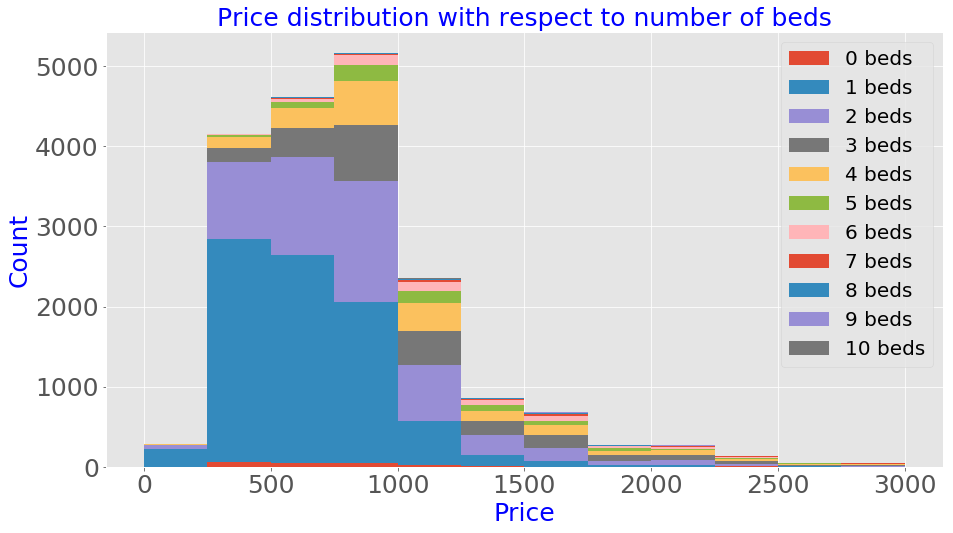

In [96]:
df=listings
title='Price distribution with respect to number of beds'
plot_price_wrt_number_of_beds(df,title)

## 3 (g) Kopier Training set og Test set


In [109]:
train_backup = train.copy()


In [110]:
train.shape

(15238, 25)

In [114]:
test_backup = test.copy()


In [115]:
test.shape

(3836, 25)

## 4(b) Skabe etiketkode for de kategoriske variabler for vores prediction model

In [117]:
def encode(df):
    categorical_features = list(df.columns[df.dtypes == 'object'])
    for i in  categorical_features:
        df[i] = LabelEncoder().fit_transform(df[i])
    return df

In [118]:
train = encode(train)

In [119]:
train.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture
0,0,1,1,6,55.69005,12.56350,0,0,2,1.0,1.0,0.0,4,11.606576,799.0,0.0,300.0,2,200.0,3,31,29,1,2,0
1,0,1,0,6,55.69518,12.54993,0,2,2,1.0,1.0,1.0,4,7.134305,342.0,0.0,0.0,1,0.0,2,1125,10,0,0,0
2,0,1,0,2,55.70126,12.52511,0,0,8,1.0,4.0,6.0,4,8.361966,1297.0,4000.0,800.0,1,0.0,5,30,19,0,1,0
3,0,1,0,9,55.66860,12.54309,0,0,2,1.0,1.0,1.0,4,12.265763,628.0,2500.0,150.0,2,0.0,3,1125,6,0,1,0
4,0,1,1,9,55.67126,12.55034,18,0,4,2.0,2.0,2.0,4,12.615390,3201.0,5000.0,400.0,2,200.0,2,1125,12,0,1,0


In [120]:
test = encode(test)

In [121]:
test.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture
0,0,1,1,4,55.67939,12.55055,0,0,2,1.5,1.0,1.0,4,8.297283,1222.0,6824.0,478.0,2,136.0,4,22,7,0,1,0
1,0,1,1,9,55.66863,12.55255,0,0,2,1.0,1.0,1.0,4,9.331988,648.0,1500.0,200.0,2,0.0,3,21,44,0,2,1
2,0,1,0,4,55.68034,12.54528,0,0,5,1.0,4.0,5.0,4,11.095507,1495.0,747.0,373.0,1,0.0,6,40,30,0,2,0
3,0,1,0,6,55.69305,12.54908,0,0,2,1.0,1.0,1.0,4,9.799839,437.0,0.0,500.0,2,300.0,3,14,56,0,1,0
4,1,1,1,5,55.67328,12.59116,0,0,6,1.0,3.0,4.0,4,14.412698,1699.0,2000.0,650.0,3,350.0,2,30,79,0,1,0


## 4(c) Undersøg sammenhængen mellem funktionerne i træningsdatasættet

In [122]:
corrmat = train.corr()
print (corrmat['price'].sort_values(ascending=False)[:15], '\n')
print (corrmat['price'].sort_values(ascending=False)[-10:])


price                  1.000000
accommodates           0.553041
bedrooms               0.507417
beds                   0.435021
cleaning_fee           0.360344
bathrooms              0.305884
guests_included        0.301648
amenities              0.207382
property_type          0.191565
longitude              0.161633
cancellation_policy    0.146707
extra_people           0.128407
security_deposit       0.096655
maximum_nights         0.061858
bed_type               0.045517
Name: price, dtype: float64 

host_is_superhost                0.023699
instant_bookable                 0.019414
host_has_profile_pic             0.010088
neighbourhood_cleansed           0.005847
require_guest_profile_picture    0.004167
host_identity_verified          -0.007835
number_of_reviews               -0.016509
minimum_nights                  -0.025060
latitude                        -0.039416
room_type                       -0.331563
Name: price, dtype: float64


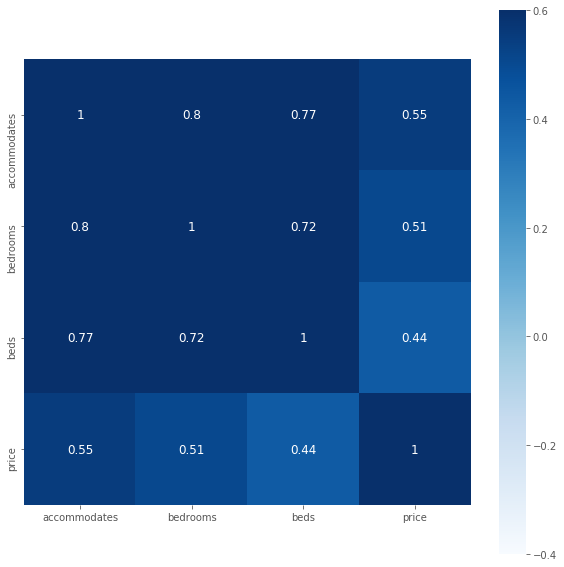

In [123]:
top_corr_features = corrmat.index[abs(corrmat["price"])>0.4]
plt.figure(figsize=(10,10))
sns.heatmap(train[top_corr_features].corr(), annot = True, cmap = "Blues", 
                cbar = True, vmin = -0.4, vmax = 0.6, square=True, annot_kws={"size": 12})


# 5. Machine Learning - Modellen

## 5(a) Den endelige opdelingsprocess i testsættet og i Træningssættet
- Lav en kopi

In [262]:

X_train=train.copy()
X_test=test.copy()

y_train = np.log1p(X_train['price'])
y_test  = np.log1p(X_test['price'])


drop_features=['price']
X_train.drop(drop_features,axis=1,inplace = True)
X_test.drop(drop_features,axis=1,inplace = True)

In [263]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15238, 24), (15238,), (3836, 24), (3836,))

###  Det mest vigtige nyttige funktioner til at vise resultaterne og plotsne


- indstillings parametre til de vigtige metrics og score: R2,RMSE,Average Error,Accuracy.

- Matplot har en indbygget funktion til at oprette scatterplots,residuals plot ved at bruge  "scatter". En scatter-plot viser dataene som en samling af datapoint. Placeringen af et punkt afhænger af dets to-dimensionelle værdi i x-y aksen.

- Sklearn har en indbygget funktion kaldet "from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression". Den kan bruges til at udtrække funktionernes betydning i datasættet ved plotte det. Denne funktion vil blive brugt i Decision Tree modeller : Random forest, XGBOOST og Gradient Boosting.

In [264]:
def evaluate(model, X, y, title):
    predictions = model.predict(X)
    errors = abs(np.expm1(predictions) - np.expm1(y))
    mape = 100 * np.mean(errors / np.expm1(y))
    accuracy = 100 - mape
    score_gbr = model.score(X,y)
    rsquared = r2_score(y,predictions)
    rmse_gbr = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(predictions)))
    
    print(title)
    print('R^2: {:0.4f}'.format(rsquared))
    print('RMSE: DKK{:0.4f} '.format(rmse_gbr))
    print('Average Error: DKK{:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.3f}%.'.format(accuracy),'\n')
    
    return predictions

    
def scatter_plot(prediction,y,title):
    plt.rcParams['figure.figsize']=(10,4)
    plt.style.use(style='ggplot')
    plt.scatter(x=prediction, y=y, alpha=.75)
    plt.ylabel('log(input price)',fontsize=16)
    plt.xlabel('log(predicted price)',fontsize=16)
    plt.tick_params(labelsize=16)
    plt.title(title,fontsize=16)
    plt.show()    
    
def feature_extraction(importances,title):
    plt.rcParams['figure.figsize']=(12,6)
    importances[0:15].iloc[::-1].plot(kind='barh',legend=False,fontsize=16)
    plt.tick_params(labelsize=18)
    plt.ylabel("Feature",fontsize=20)
    plt.xlabel("Importance viariable",fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
def scatter_plot2(prediction1,y1,prediction2,y2,title):
    a=min(min(prediction1),min(y1),min(prediction2),min(y2))-0.2
    b=max(max(prediction1),max(y1),max(prediction2),max(y2))+0.2
    plt.rcParams['figure.figsize']=(10,4)
    plt.style.use(style='ggplot')
    plt.scatter(x=prediction1, y=prediction1-y1, color='red',label='Training data',alpha=.75)
    plt.scatter(x=prediction2, y=prediction2-y2, color='blue', marker='s', label='Test data',alpha=.75)
    plt.hlines(y = 0, xmin = a, xmax = b, color = "black")
    plt.ylabel('log(input price)',fontsize=16)
    plt.xlabel('log(predicted price)',fontsize=16)
    plt.tick_params(labelsize=16)
    plt.title(title,fontsize=16)
    plt.legend(fontsize=16)
    plt.show()    


def scatter_plot3(prediction1,y1,prediction2,y2,title):
    a=min(min(prediction1),min(y1),min(prediction2),min(y2))-0.2
    b=max(max(prediction1),max(y1),max(prediction2),max(y2))+0.2
    plt.rcParams['figure.figsize']=(10,4)
    plt.style.use(style='ggplot')
    plt.scatter(x=prediction1, y=y1, color='red',label='Training data',alpha=.75)
    plt.scatter(x=prediction2, y=y2, color='blue', marker='s', label='Test data',alpha=.75)
    plt.plot([a, b], [a, b], c = "black")
    plt.ylabel('log(input price)',fontsize=16)
    plt.xlabel('log(predicted price)',fontsize=16)
    plt.tick_params(labelsize=16)
    plt.title(title,fontsize=16)
    plt.legend(fontsize=16)
    plt.show()    



## 5(a) Multiple Linear Regression

### Multiple Linear Regression ved brug a en 10-fold cross validation

In [265]:
lr=LinearRegression(n_jobs=-1)
param_grid = dict(fit_intercept=[True,False], 
                  normalize=[True,False], 
                  copy_X=[True,False])

grid_lr=GridSearchCV(lr, param_grid, cv=10, scoring='neg_mean_squared_error')

grid_lr.fit(X_train,y_train)


print("Linear Regression grid.best_score_: {}".format(grid_lr.best_score_))
print("Linear Regression grid.best_params_: {}".format(grid_lr.best_params_))
print("Linear Regression grid.best_estimator_: {}".format(grid_lr.best_estimator_))


model_lr = grid_lr.best_estimator_


Linear Regression grid.best_score_: -0.1304739399182789
Linear Regression grid.best_params_: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Linear Regression grid.best_estimator_: LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=True)


Linear Regression: training set model performance
R^2: 0.4925
RMSE: DKK385.7042 
Average Error: DKK236.3252
Accuracy = 71.211%. 

Linear Regression: test set model performance
R^2: 0.4852
RMSE: DKK401.1139 
Average Error: DKK242.9908
Accuracy = 71.388%. 



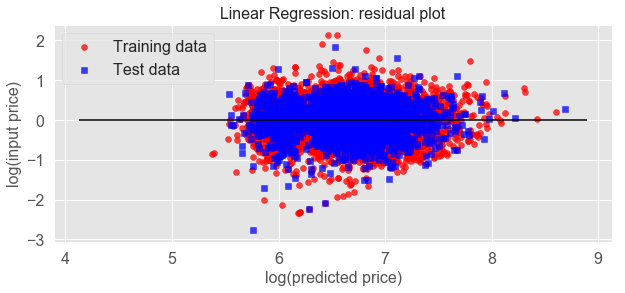

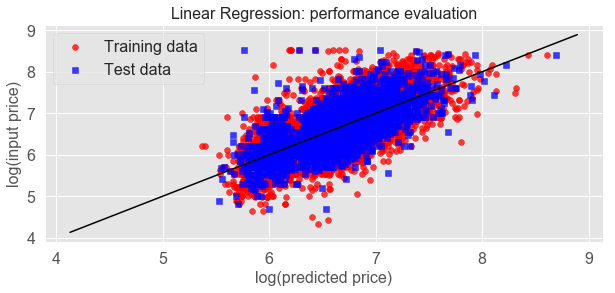

In [266]:
title0='Linear Regression:'
model_tmp = model_lr

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)



## 5(b) Lasso Regression 

In [126]:
lasso = Lasso(max_iter = 10000)
param_grid =dict(alpha=np.logspace(-4,1,50))
grid_lasso = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

grid_lasso.fit(X_train, y_train)


print("Linear Regression grid.best_score_: {}".format(grid_lasso.best_score_))
print("Linear Regression grid.best_params_: {}".format(grid_lasso.best_params_))
print("Linear Regression grid.best_estimator_: {}".format(grid_lasso.best_estimator_))


model_lasso = grid_lasso.best_estimator_

Linear Regression grid.best_score_: -0.1304805005048771
Linear Regression grid.best_params_: {'alpha': 8.733261623828437e-06}
Linear Regression grid.best_estimator_: Lasso(alpha=8.733261623828437e-06, copy_X=True, fit_intercept=True,
   max_iter=13000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


Lasso Regression: training set model performance
R^2: 0.4925
RMSE: DKK385.6952 
Average Error: DKK236.3216
Accuracy = 71.211%. 

Lasso Regression: test set model performance
R^2: 0.4851
RMSE: DKK401.1249 
Average Error: DKK243.0116
Accuracy = 71.385%. 



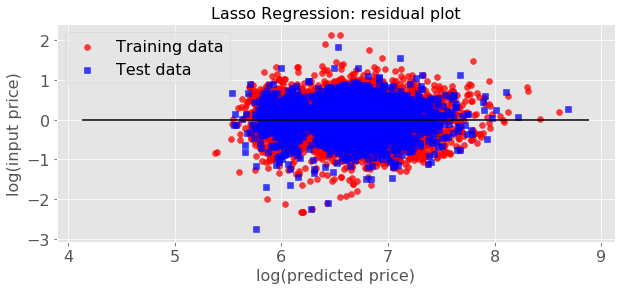

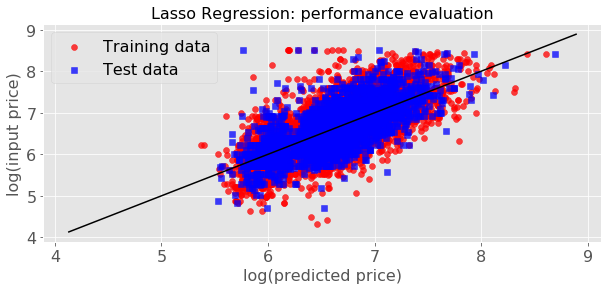

In [125]:
title0='Lasso Regression:'
model_tmp = model_lasso

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

## 5(c) Hyperparameter-tuned Random forest regression 

In [267]:
rf= RandomForestRegressor(random_state=1, n_jobs=-2, max_features='log2')

param_grid = dict(n_estimators=[3000,4000,5000],
                  max_depth=[None, 4],
                  min_samples_leaf=[1,2])

grid_rf=GridSearchCV(rf, param_grid, cv=10, scoring='neg_mean_squared_error')

grid_rf.fit(X_train,y_train)

print("Random forest grid.best_score_ {}".format(grid_rf.best_score_))
print("Random forest grid.best_params_ {}".format(grid_rf.best_params_))
print("Random forest grid.best_estimator_ {}".format(grid_rf.best_estimator_))

model_rf = grid_rf.best_estimator_


Random forest grid.best_score_ -0.09873831883438806
Random forest grid.best_params_ {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 5000}
Random forest grid.best_estimator_ RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-2,
           oob_score=False, random_state=1, verbose=0, warm_start=False)


Random Forest Regression: training set model performance
R^2: 0.9481
RMSE: DKK146.9326 
Average Error: DKK79.4551
Accuracy = 91.157%. 

Random Forest Regression: test set model performance
R^2: 0.6059
RMSE: DKK343.3254 
Average Error: DKK211.0458
Accuracy = 74.912%. 



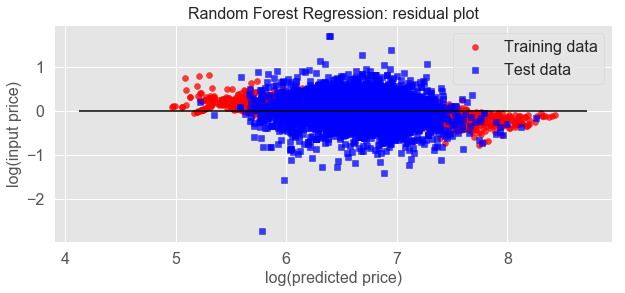

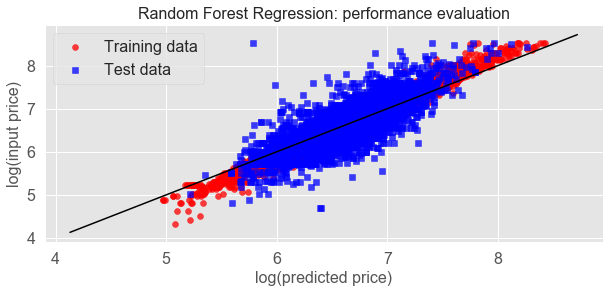

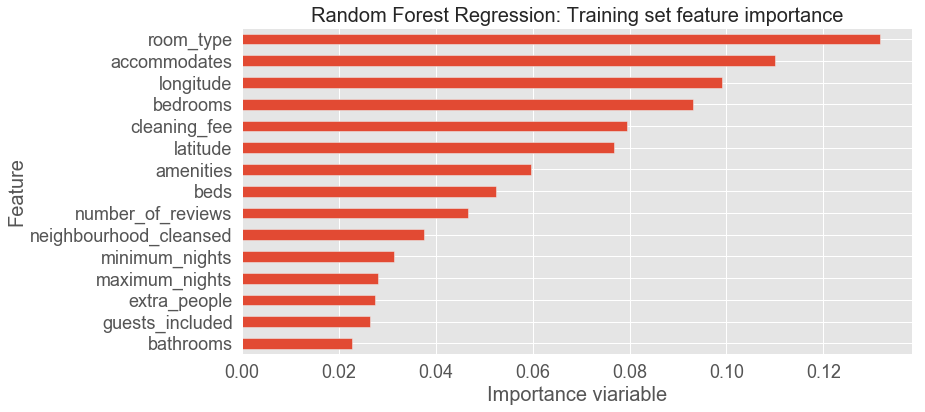

In [268]:
title0='Random Forest Regression:'
model_tmp = model_rf

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)



title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

importances_train = pd.DataFrame({'Feature':X_train.columns, 'Importance':model_rf.feature_importances_})
importances_train = importances_train.sort_values('Importance',ascending=False).set_index('Feature')
feature_extraction(importances_train,'Random Forest Regression: Training set feature importance')

## 5(d) XGB model with hyperparameter tuning

In [316]:
xgbr = xgb.XGBRegressor(random_state=1, n_jobs=-2,learning_rate=0.01)

param_grid = dict(gamma=[0.03,0.04], 
              max_depth=[4, 8, 12],
              n_estimators=[3000,5000])



grid_xgbr=GridSearchCV(xgbr, param_grid, cv=10, scoring='neg_mean_squared_error')

grid_xgbr.fit(X_train,y_train)


print("XGB grid.best_score_ {}".format(grid_xgbr.best_score_))
print("XGB grid.best_params_ {}".format(grid_xgbr.best_params_))
print("XGB grid.best_estimator_ {}".format(grid_xgbr.best_estimator_))


model_xgbr = grid_xgbr.best_estimator_


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:30:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:30:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:30:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:31:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:32:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:32:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:32:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:33:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:33:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:33:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:34:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:34:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:34:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:35:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:35:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:36:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:36:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:37:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:37:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:38:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:38:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:39:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:39:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:40:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:40:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:41:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:43:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:43:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:44:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:46:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:46:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:47:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:48:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:49:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:49:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:50:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:51:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:52:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:52:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:53:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:54:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:54:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:55:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:56:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:59:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:00:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:01:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:02:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:03:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:04:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:05:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:08:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:08:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:08:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:08:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:08:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:09:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:09:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:09:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:10:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:10:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:10:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:11:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:11:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:11:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:12:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:13:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:13:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:14:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:15:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:15:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:16:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:16:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:16:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:17:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:18:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:19:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:19:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:20:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:21:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:22:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:22:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:23:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:24:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:24:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:25:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:26:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:26:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:27:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:28:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:28:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:29:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:30:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:31:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:32:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:34:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:36:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:38:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:39:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:41:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:42:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\fatih\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB grid.best_score_ -0.09551363632443692
XGB grid.best_params_ {'gamma': 0.03, 'max_depth': 4, 'n_estimators': 3000}
XGB grid.best_estimator_ XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.03,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=-2, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)


XGB Regression: training set model performance
R^2: 0.7052
RMSE: DKK282.7867 
Average Error: DKK177.9360
Accuracy = 78.195%. 

XGB Regression: test set model performance
R^2: 0.6151
RMSE: DKK333.6534 
Average Error: DKK206.3917
Accuracy = 75.188%. 



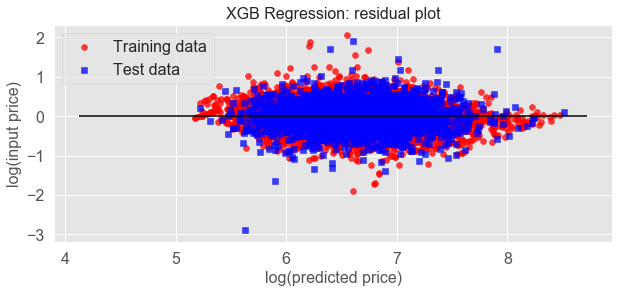

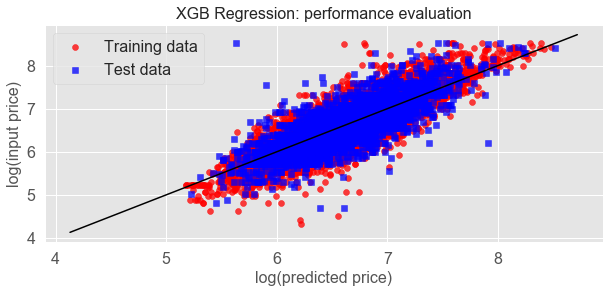

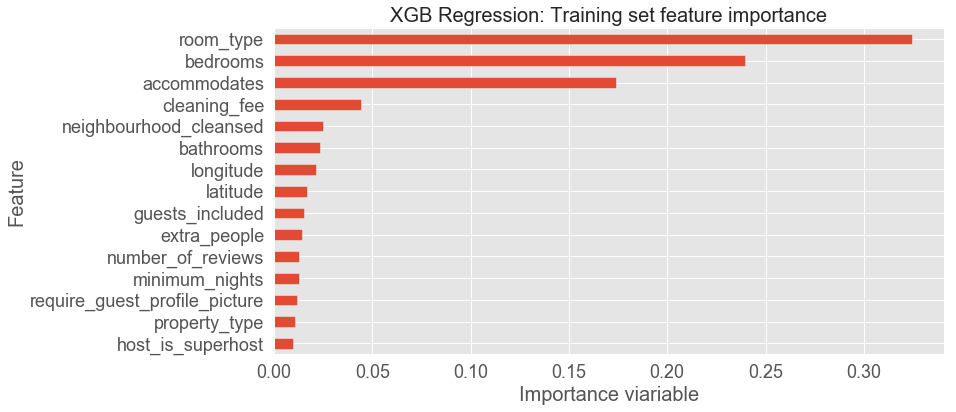

In [317]:
title0='XGB Regression:'
model_tmp = model_xgbr

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

importances_train = pd.DataFrame({'Feature':X_train.columns, 'Importance':model_xgbr.feature_importances_})
importances_train = importances_train.sort_values('Importance',ascending=False).set_index('Feature')
feature_extraction(importances_train,'XGB Regression: Training set feature importance')

# 5(e) Hyperparameter tuned gradient boosting Regression

In [322]:
gbr = GradientBoostingRegressor(min_samples_split=400,
                                min_samples_leaf=50,
                                subsample=0.8,
                                random_state=1,
                               learning_rate=0.01,
                               max_features='sqrt')

param_grid = dict(n_estimators=[6000,7000], max_depth=[8,12,16])

grid_gbr=GridSearchCV(gbr, param_grid, cv=10, scoring='neg_mean_squared_error',n_jobs=-2)

grid_gbr.fit(X_train,y_train)

print("Random forest grid.best_score_ {}".format(grid_gbr.best_score_))
print("Random forest grid.best_params_ {}".format(grid_gbr.best_params_))
print("Random forest grid.best_estimator_ {}".format(grid_gbr.best_estimator_))

model_gbr = grid_gbr.best_estimator_


Random forest grid.best_score_ -0.0957164434918605
Random forest grid.best_params_ {'max_depth': 8, 'n_estimators': 6000}
Random forest grid.best_estimator_ GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=400,
             min_weight_fraction_leaf=0.0, n_estimators=6000,
             n_iter_no_change=None, presort='auto', random_state=1,
             subsample=0.8, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)


Gradient Boosting Regression: training set model performance
R^2: 0.7766
RMSE: DKK252.0491 
Average Error: DKK155.3125
Accuracy = 81.243%. 

Gradient Boosting Regression: test set model performance
R^2: 0.6141
RMSE: DKK327.3789 
Average Error: DKK206.5238
Accuracy = 75.051%. 



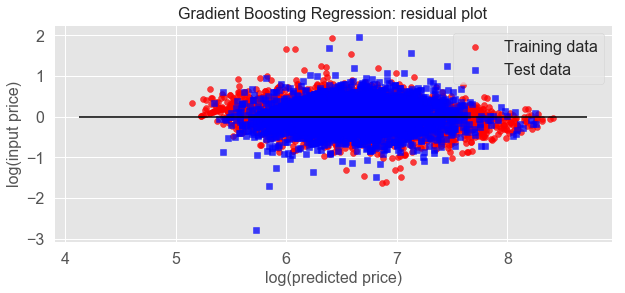

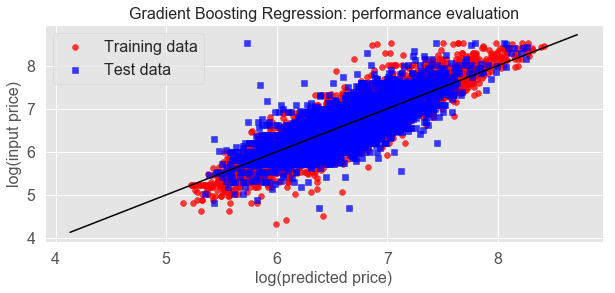

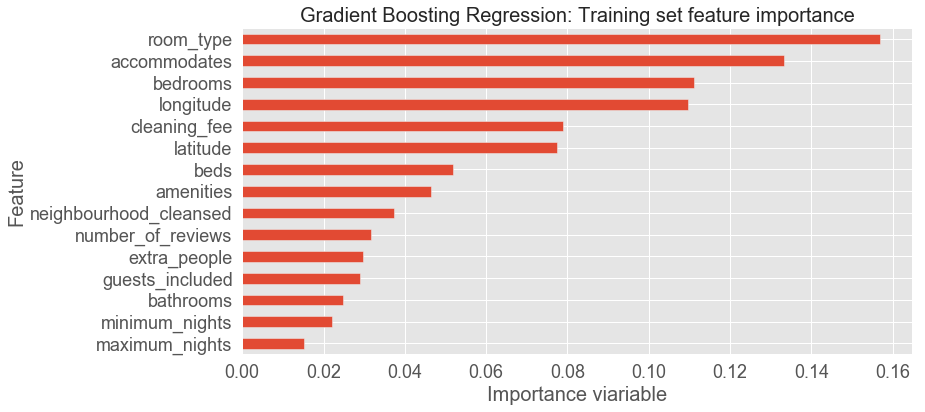

In [324]:
title0='Gradient Boosting Regression:'
model_tmp = model_gbr



title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)

importances_train = pd.DataFrame({'Feature':X_train.columns, 'Importance':model_tmp.feature_importances_})
importances_train = importances_train.sort_values('Importance',ascending=False).set_index('Feature')
feature_extraction(importances_train,'Gradient Boosting Regression: Training set feature importance')

# 5(f) Multi Layer Perceptron - Neural Network 

In [355]:

my_pipeline_NN.get_params()

{'memory': None,
 'steps': [('imputer',
   Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)),
  ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('mlpregressor',
   MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
          beta_2=0.999, early_stopping=False, epsilon=1e-08,
          hidden_layer_sizes=(100,), learning_rate='constant',
          learning_rate_init=0.001, max_iter=400, momentum=0.9,
          n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
          random_state=42, shuffle=True, solver='adam', tol=0.0001,
          validation_fraction=0.1, verbose=False, warm_start=False))],
 'imputer': Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'mlpregressor': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False

###  Opret parameternet grid search på resultaterne af  en tilfældig søgning af de bedste parametre

In [356]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'mlpregressor__activation': ['relu', 'tanh'],
    'mlpregressor__solver': ['sgd', 'adam'],
    'mlpregressor__early_stopping': [True, False],
    'mlpregressor__hidden_layer_sizes': [(100,), (100, 50), (100, 100), (100, 100, 100)],
    'mlpregressor__learning_rate_init': [0.001, 0.0001],
}

### Instant grid search modellen, med samme krydsvalidering.

In [360]:

grid_search = GridSearchCV(estimator = my_pipeline_NN,
                           param_grid = param_grid, 
                           cv = 10, n_jobs = -1, verbose = 2,
                           scoring = 'neg_median_absolute_error')

# Tilpas grid search til data

- Opret pipeline: imputation + MLP regressor
- Multi layer perceptron

In [395]:

my_pipeline_NN_grid = make_pipeline(Imputer(), StandardScaler(),
                                    MLPRegressor(hidden_layer_sizes = (100,100),
                                                 activation = 'relu',
                                                 early_stopping = False,
                                                 learning_rate_init = 0.0001,
                                                 solver = 'adam',
                                                 max_iter = 400,
                                                 random_state = 42)) 
grid_search = GridSearchCV(estimator = my_pipeline_NN_grid,
                           param_grid = param_grid, 
                           cv = 10, n_jobs = 1, verbose = 2,
                           scoring = 'neg_median_absolute_error')
# Fit the model
my_pipeline_NN_grid.fit(X_train, y_train)

C:\Users\fatih\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpregressor', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_sto...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

Multi Layer Perceptron Regressor training set model performance
R^2: 0.6801
RMSE: DKK295.1809 
Average Error: DKK186.5307
Accuracy = 77.512%. 

Multi Layer Perceptron Regressor test set model performance
R^2: 0.5321
RMSE: DKK368.4197 
Average Error: DKK230.1606
Accuracy = 72.716%. 



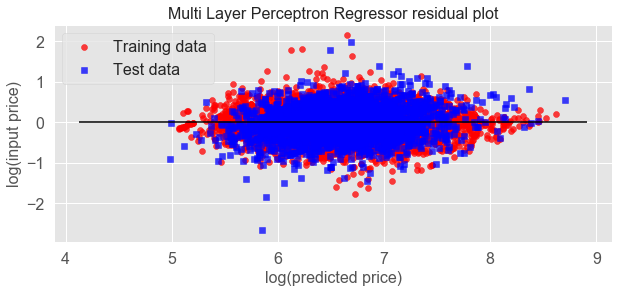

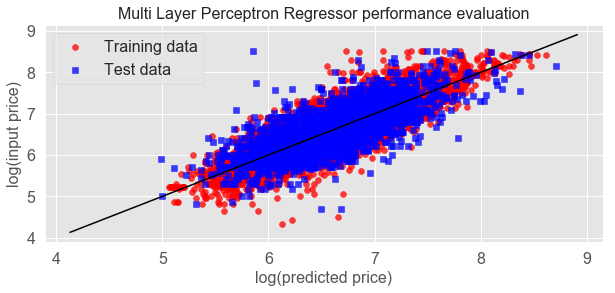

In [396]:
title0='Multi Layer Perceptron Regressor'
model_tmp = my_pipeline_NN_grid

title=title0 + ' training set model performance'
prediction_train=evaluate(model_tmp, X_train, y_train,title)

title=title0 + ' test set model performance'
prediction_test=evaluate(model_tmp, X_test, y_test,title)

title=title0 + ' residual plot'
scatter_plot2(prediction_train,y_train,prediction_test,y_test,title)

title=title0 + ' performance evaluation'
scatter_plot3(prediction_train,y_train,prediction_test,y_test,title)


# 6 Model Comparison

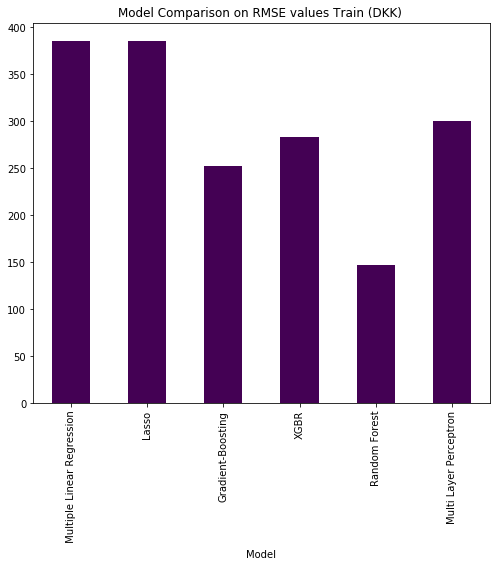

In [59]:
metric_val = pd.DataFrame({'RMSE':[ 385.7042, 385.6952, 252.0491 , 282.7867, 146.9326, 300.5614  ],'R2score':[0.4925, 0.4925, 0.7766, 0.7052,  0.9481, 0.6693],'Model':[' Multiple Linear Regression','Lasso','Gradient-Boosting','XGBR','Random Forest','Multi Layer Perceptron']},index=[0,1,2,3,4,5])
fig,ax=plt.subplots(1,figsize=(18,7))
plt.subplot(1,2,1)
metric_val.set_index('Model')['RMSE'].plot.bar(colormap='viridis');
plt.title('Model Comparison on RMSE values Train (DKK) ');



In [ ]:
metric_val = pd.DataFrame({'RMSE':[ 401.1139, 401.1249, 265.4192, 297.6979, 157.6521 ],'R2score':[0.4852, 0.4851, 0.7753, 0.7050,  0.9481],'Model':['Linear Regression','Lasso','Gradient-Boosting','XGBR','Random Forest']},index=[0,1,2,3,4])
fig,ax=plt.subplots(1,2,figsize=(15,4))
plt.subplot(1,2,1)
metric_val.set_index('Model')['RMSE'].plot.bar(colormap='viridis');
plt.title('Model Comparison on RMSE values Train ');

plt.subplot(1,2,2)
metric_val.set_index('Model')['R2score'].plot.bar(colormap='cividis')
plt.title('Model Comparison on R2Score values Train');

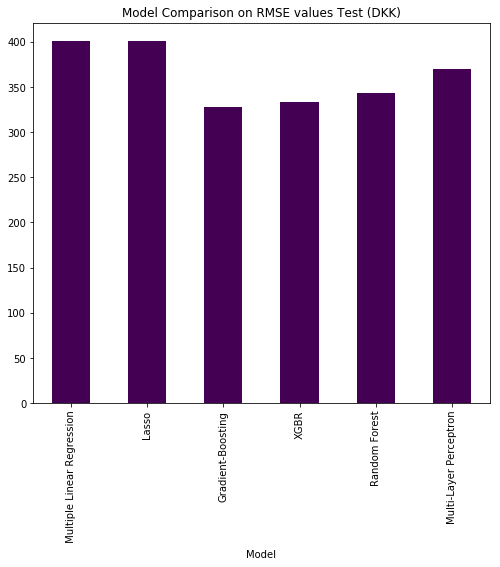

In [60]:
metric_val = pd.DataFrame({'RMSE':[ 401.1139, 401.1249, 327.3789 , 333.6534, 343.3254, 369.7646  ],'R2score':[0.4852, 0.4851, 0.6141, 0.6151,  0.6059, 0.5482],'Model':[' Multiple Linear Regression','Lasso','Gradient-Boosting','XGBR','Random Forest', 'Multi-Layer Perceptron']},index=[0,1,2,3,4,5])
fig,ax=plt.subplots(1,figsize=(18,7))
plt.subplot(1,2,1)
metric_val.set_index('Model')['RMSE'].plot.bar(colormap='viridis');
plt.title('Model Comparison on RMSE values Test (DKK)');


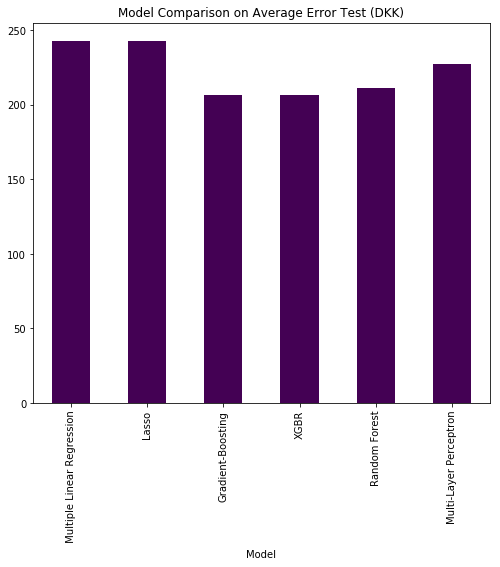

In [100]:
metric_val = pd.DataFrame({'Average':[ 242.9908, 243.0116, 206.5238, 206.3917, 211.0458, 227.577  ],'Model':[' Multiple Linear Regression','Lasso','Gradient-Boosting','XGBR','Random Forest', 'Multi-Layer Perceptron']},index=[0,1,2,3,4,5])
fig,ax=plt.subplots(1,figsize=(18,7))
plt.subplot(1,2,1)
metric_val.set_index('Model')['Average'].plot.bar(colormap='viridis');
plt.title('Model Comparison on Average Error Test (DKK)');

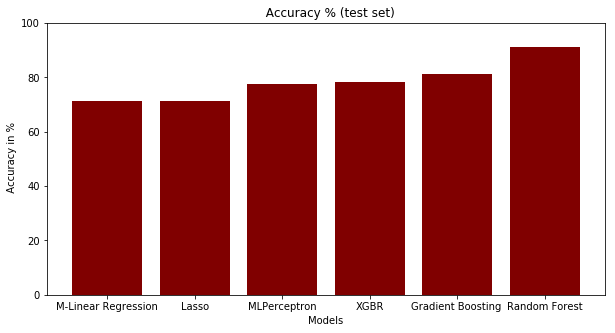

In [2]:

import numpy as np
labels = np.array(['M-Linear Regression','Lasso','Gradient Boosting ', 'XGBR', 'Random Forest', 'MLPerceptron'])
error_val = np.array([71.211, 71.211, 81.243, 78.195,  91.157, 77.512 ])


pos = np.arange(error_val.shape[0])
srt = np.argsort(error_val)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(pos, error_val[srt], align = 'center', color='maroon')
plt.xticks(pos, labels[srt])
plt.xlabel('Models')
plt.ylabel('  Accuracy in % ')
plt.title('  Accuracy % (test set)' )
plt.ylim(0,100)
plt.show()

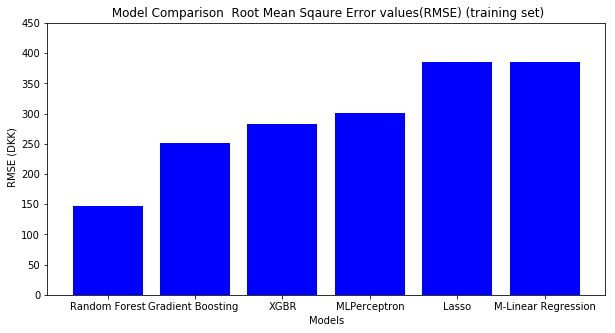

In [96]:

import numpy as np
labels = np.array(['M-Linear Regression','Lasso','Gradient Boosting ', 'XGBR', 'Random Forest', 'MLPerceptron'])
error_val = np.array([385.7042, 385.6952, 252.0491 , 282.7867, 146.9326, 300.5614  ])


pos = np.arange(error_val.shape[0])
srt = np.argsort(error_val)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(pos, error_val[srt], align = 'center', color='blue')
plt.xticks(pos, labels[srt])
plt.xlabel('Models')
plt.ylabel(' RMSE (DKK)')
plt.title(' Model Comparison  Root Mean Sqaure Error values(RMSE) (training set)')
plt.ylim(0,450)
plt.show()

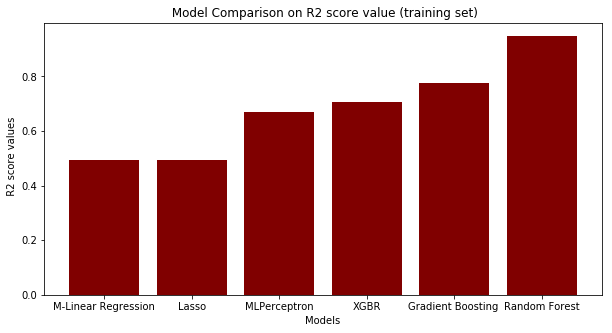

In [93]:

import numpy as np
labels = np.array(['M-Linear Regression','Lasso','Gradient Boosting ', 'XGBR', 'Random Forest', 'MLPerceptron'])
error_val = np.array([0.4925, 0.4925, 0.7766, 0.7052,  0.9481, 0.6693 ])


pos = np.arange(error_val.shape[0])
srt = np.argsort(error_val)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(pos, error_val[srt], align = 'center', color='maroon')
plt.xticks(pos, labels[srt])
plt.xlabel('Models')
plt.ylabel('  R2 score values')
plt.title(' Model Comparison on R2 score value (training set)' )
plt.ylim(0,)
plt.show()

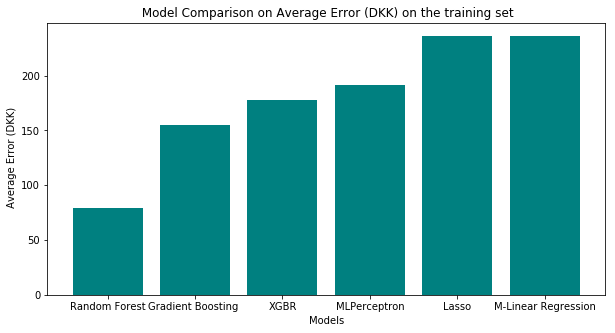

In [94]:

labels = np.array(['M-Linear Regression','Lasso','Gradient Boosting ', 'XGBR', 'Random Forest', 'MLPerceptron'])
error_val = np.array([236.3252, 236.3216, 155.3125, 177.9360,  79.4551, 191.1895 ])

# Arrange bars
pos = np.arange(error_val.shape[0])
srt = np.argsort(error_val)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(pos, error_val[srt], align = 'center', color='teal')
plt.xticks(pos, labels[srt])
plt.xlabel('Models')
plt.ylabel(' Average Error (DKK)')
plt.title(' Model Comparison on Average Error (DKK) on the training set' )
plt.ylim(0,)
plt.show()

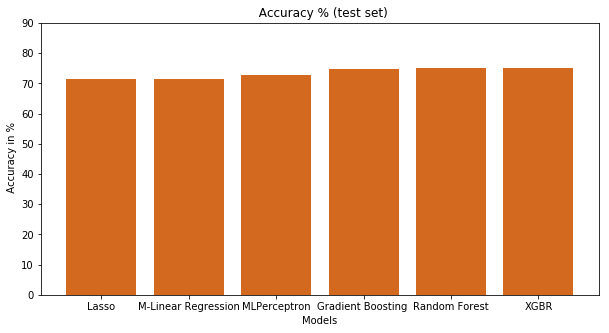

In [14]:

labels = np.array(['M-Linear Regression','Lasso','Gradient Boosting ', 'XGBR', 'Random Forest', 'MLPerceptron'])
error_val = np.array([71.388, 71.385, 74.912, 75.188,  75.051, 72.735 ])

pos = np.arange(error_val.shape[0])
srt = np.argsort(error_val)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(pos, error_val[srt], align = 'center', color='chocolate')
plt.xticks(pos, labels[srt])
plt.xlabel('Models')
plt.ylabel('  Accuracy in % ')
plt.title('  Accuracy % (test set)' )
plt.ylim(0,90)
plt.show()

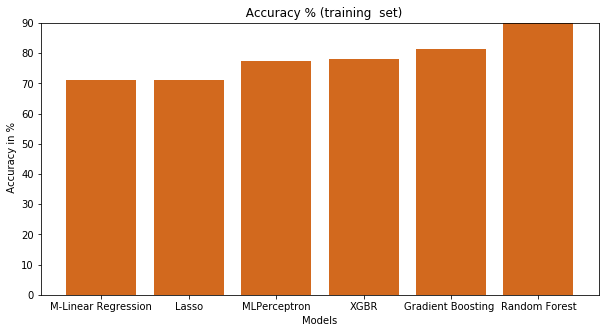

In [15]:
labels = np.array(['M-Linear Regression','Lasso','Gradient Boosting ', 'XGBR', 'Random Forest', 'MLPerceptron'])
error_val = np.array([71.211, 71.211, 81.243, 78.195,  91.157, 77.512 ])


pos = np.arange(error_val.shape[0])
srt = np.argsort(error_val)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(pos, error_val[srt], align = 'center', color= 'chocolate')
plt.xticks(pos, labels[srt])
plt.xlabel('Models')
plt.ylabel('  Accuracy in % ')
plt.title('  Accuracy % (training  set)' )
plt.ylim(0,90)
plt.show()